# Downscaled `tasmin` days below -70°C

This notebook is for exploring downscaled data for values below -70°C. It was designed to work for the zarr outputs from the 4km ERA5-based CMIP6 downscaling effort. 


Initial testing of the downscaled `tasmin` data revealed that data for the following models had values below -70°C:

* EC-Earth3-Veg
* HadGEM3-GC31-LL
* KACE-1-0-G
* NorESM2-MM
* TaiESM1
* MRI-ESM2-0
* MPI-ESM1-2-HR
* MIROC6

In this case, there are quite a few values found in the downscaled historical data.

This notebook simply presents downscaled `tasmin` data with days under -70°C counted and plotted in blue.

In [2]:
import os
import math
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
from xclim.core.units import convert_units_to
import matplotlib.pyplot as plt
import seaborn as sns
import gc

zarr_dir = Path(
    os.getenv("ZARR_DIR", "/center1/CMIP6/kmredilla/cmip6_4km_downscaling/adjusted")
)
sim_dir = Path(
    os.getenv("SIM_DIR", "/center1/CMIP6/kmredilla/cmip6_4km_downscaling/cmip6_zarr")
)

## Plot cold tasmin

In [11]:
def plot_cold_tasmin(model, scenario):
    zarr_store = zarr_dir.joinpath(f"tasmin_{model}_{scenario}_adjusted.zarr")

    ds = xr.open_zarr(zarr_store)
    tasmin = convert_units_to(ds.tasmin, "degC")

    # Compute the mean tasmax over time
    tasmin_mean = tasmin.mean("time")

    tamsin_cold = tasmin < -70
    tamsin_cold_count = tamsin_cold.sum("time")

    # Prepare values for histogram
    tamsin_cold_values = tasmin.where(tamsin_cold).values.flatten()
    tamsin_cold_values = tamsin_cold_values[~np.isnan(tamsin_cold_values)]

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f"Cold tasmin analysis for {model}, {scenario}", fontsize=14)

    # Plot the mean tasmin as a muted background
    axs[0].imshow(
        tasmin_mean.transpose("y", "x").values,
        cmap="Greys",
        alpha=0.5,
        interpolation="none",
    )

    # Overlay the cold day counts using a blue color palette, masking zeros for clarity
    masked_cold = np.ma.masked_where(tamsin_cold_count.T == 0, tamsin_cold_count.T)
    im = axs[0].imshow(masked_cold, cmap="Reds", alpha=0.8, interpolation="none")

    plt.colorbar(im, ax=axs[0], label="Count of Days < -70°C (Red Overlay)")
    axs[0].set_title("Mean tasmin (grey) with Cold Day Counts (< -70°C) Overlay")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")

    # Histogram subplot
    if tamsin_cold_values.size > 0:
        axs[1].hist(tamsin_cold_values, bins=30, color="blue", alpha=0.7)
        axs[1].set_xlabel("tasmin (°C)")
        axs[1].set_ylabel("Frequency")
        axs[1].set_title("Histogram of tasmin Values Where tasmin < -70°C")
    else:
        axs[1].text(
            0.5,
            0.5,
            "No tasmin values below -70°C found.",
            ha="center",
            va="center",
            fontsize=12,
        )
        axs[1].set_axis_off()

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    del ds
    del tasmin

    gc.collect()

### EC-Earth3-Veg

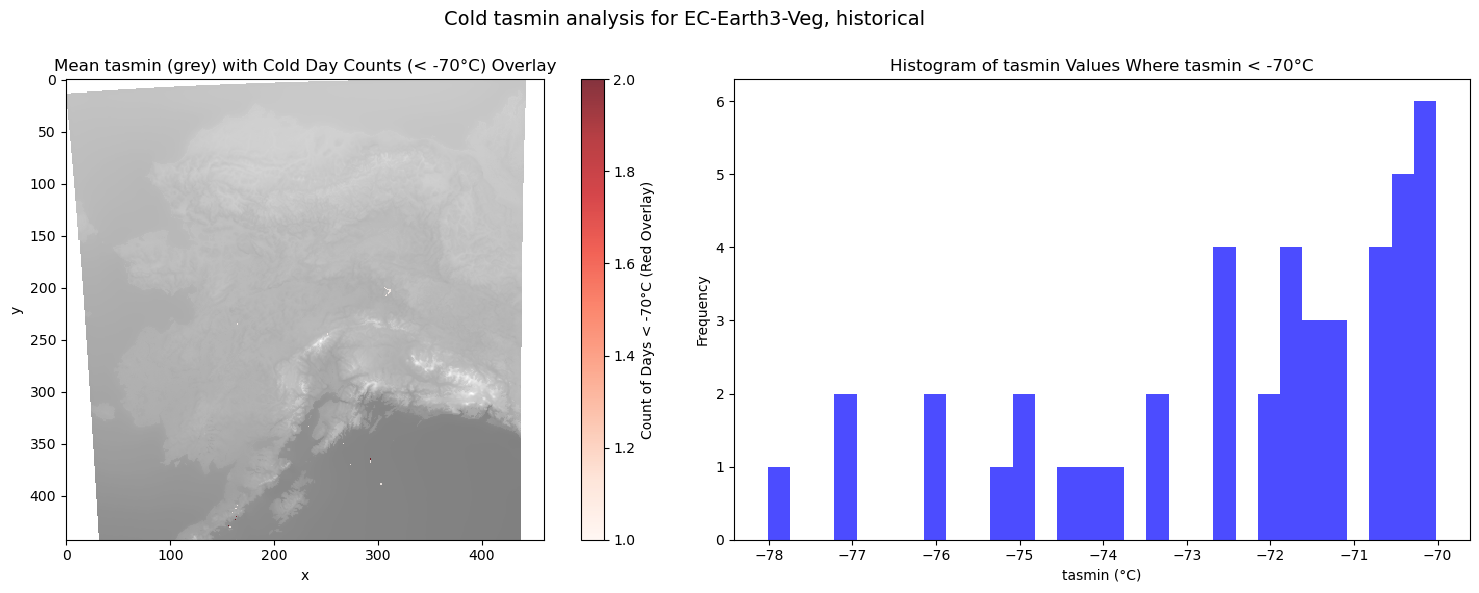

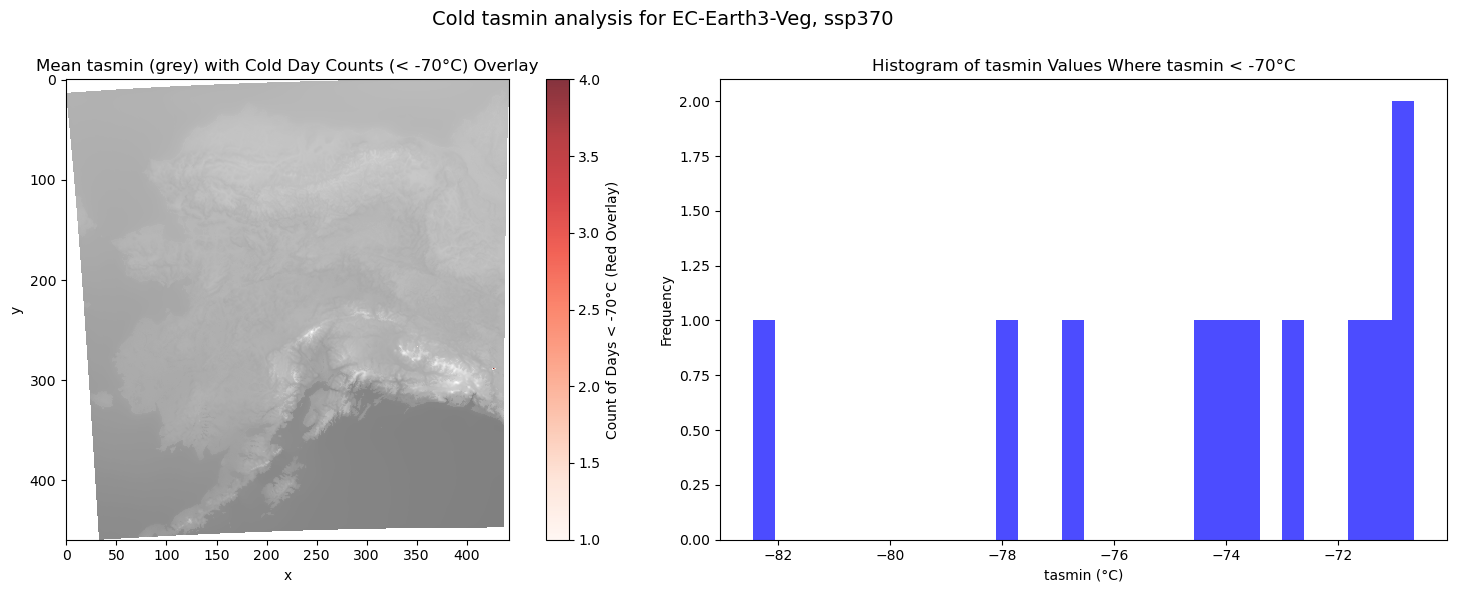

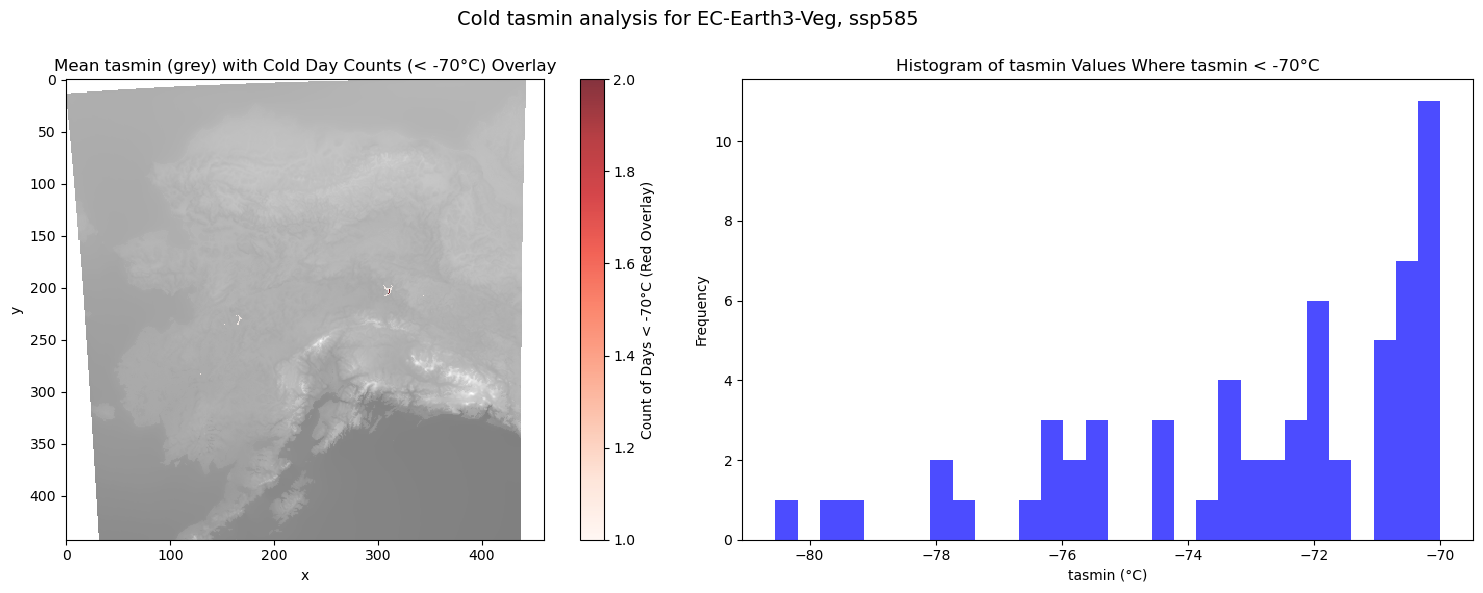

In [12]:
model = "EC-Earth3-Veg"
for scenario in ["historical", "ssp370", "ssp585"]:
    plot_cold_tasmin(model, scenario)

### GFDL-ESM4

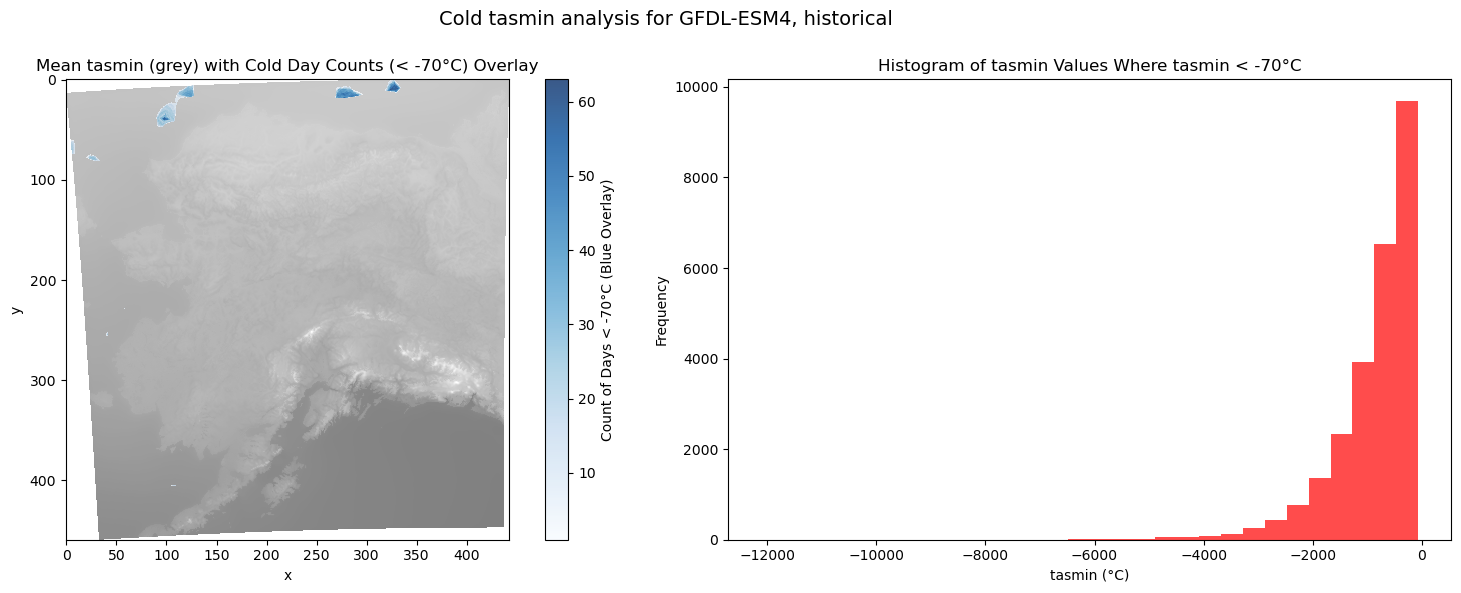

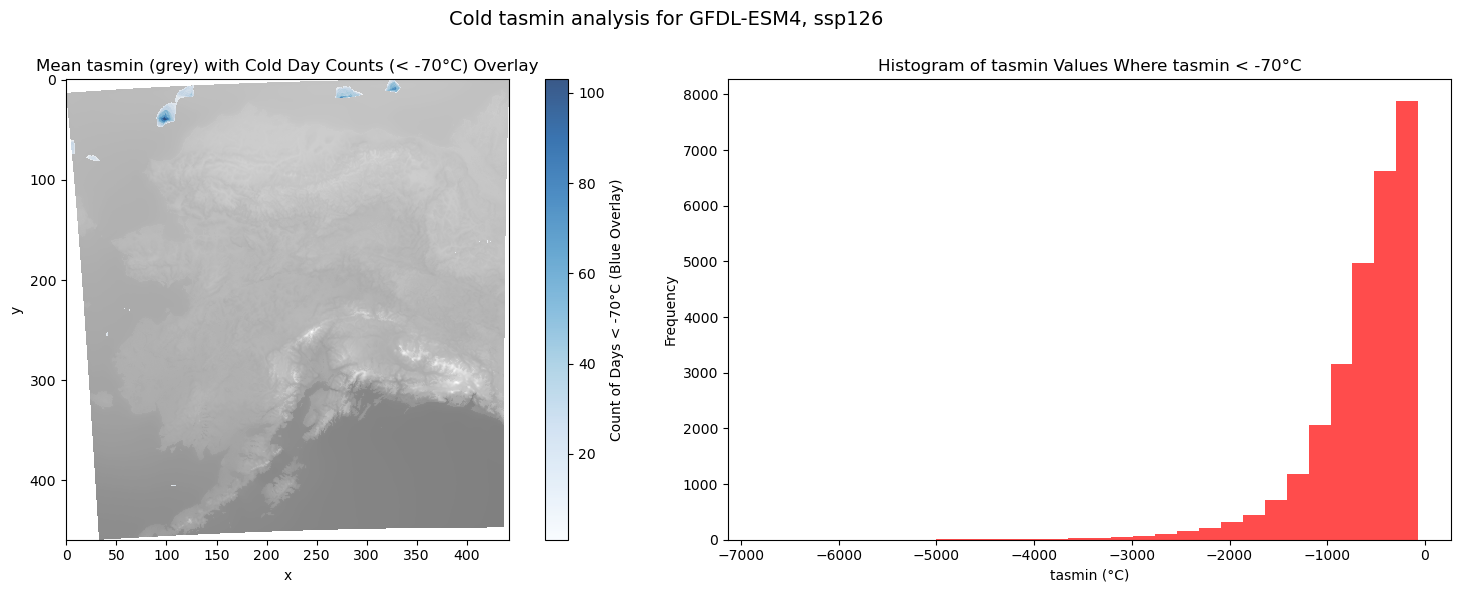

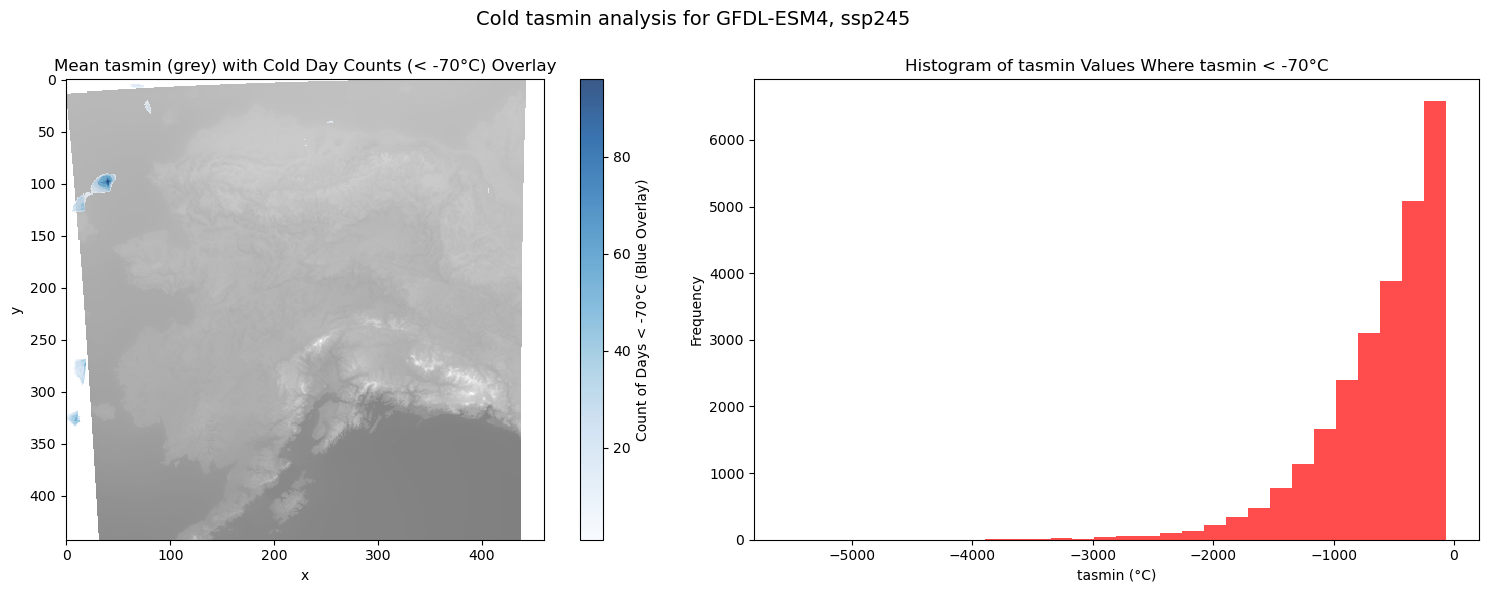

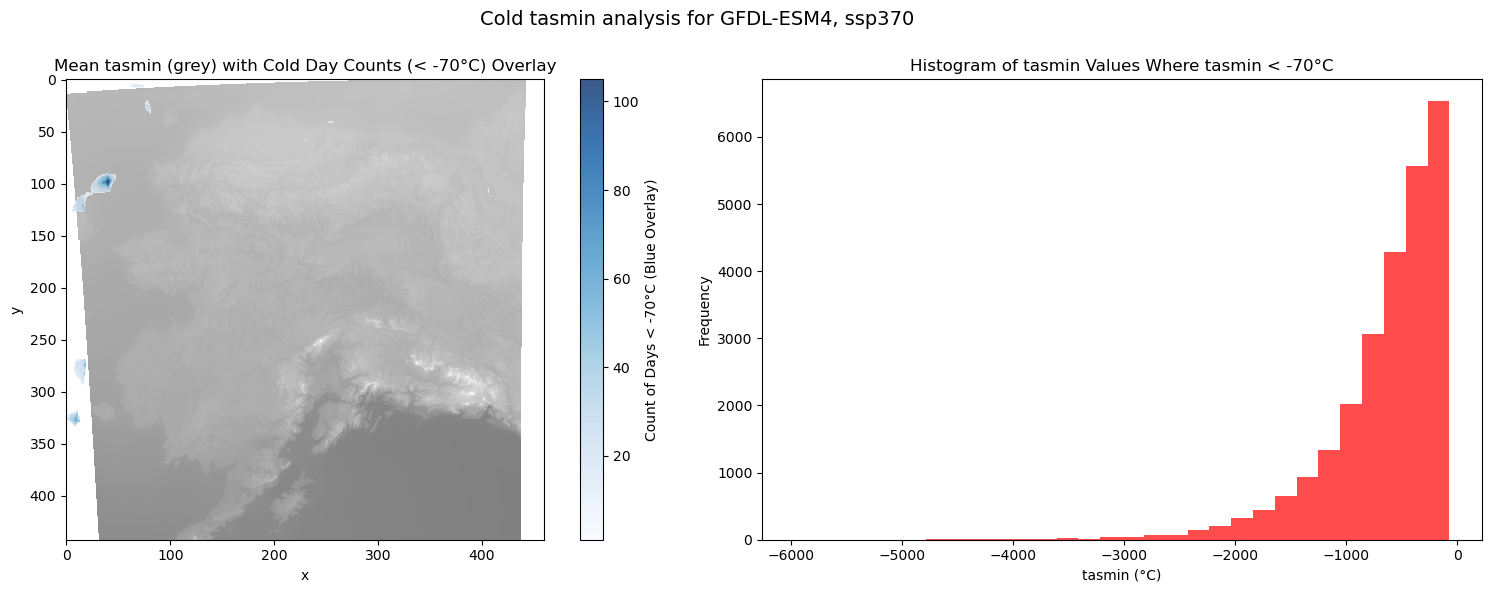

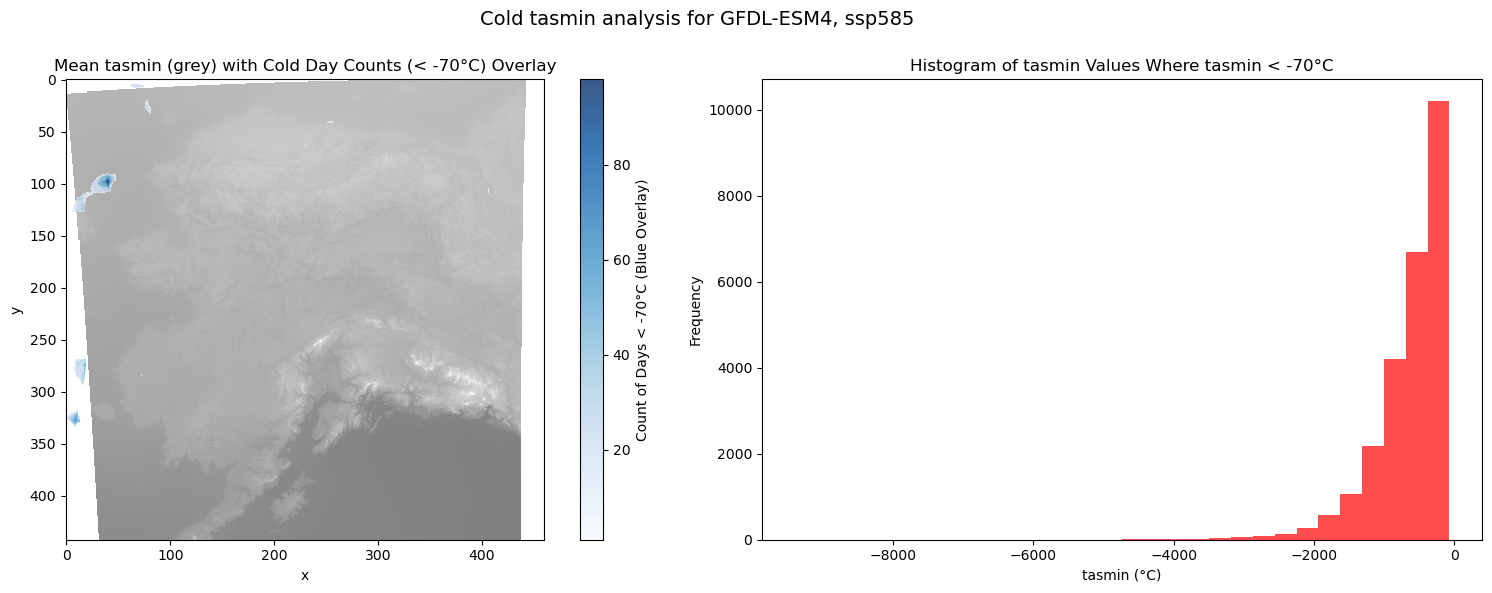

In [ ]:
model = "GFDL-ESM4"
for scenario in ["historical", "ssp126", "ssp245", "ssp370", "ssp585"]:
    plot_cold_tasmin(model, scenario)

### HadGEM3-GC31-LL

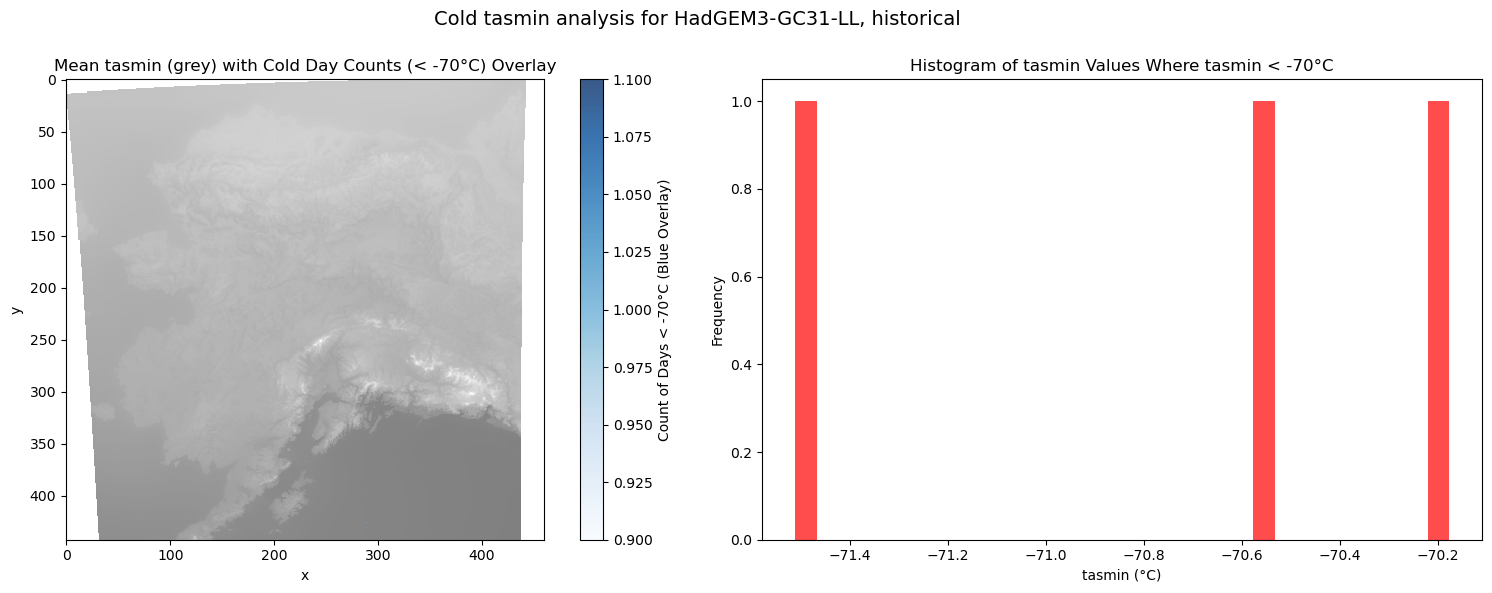

In [ ]:
model = "HadGEM3-GC31-LL"
for scenario in ["historical"]:
    plot_cold_tasmin(model, scenario)

### HadGEM3-GC31-MM

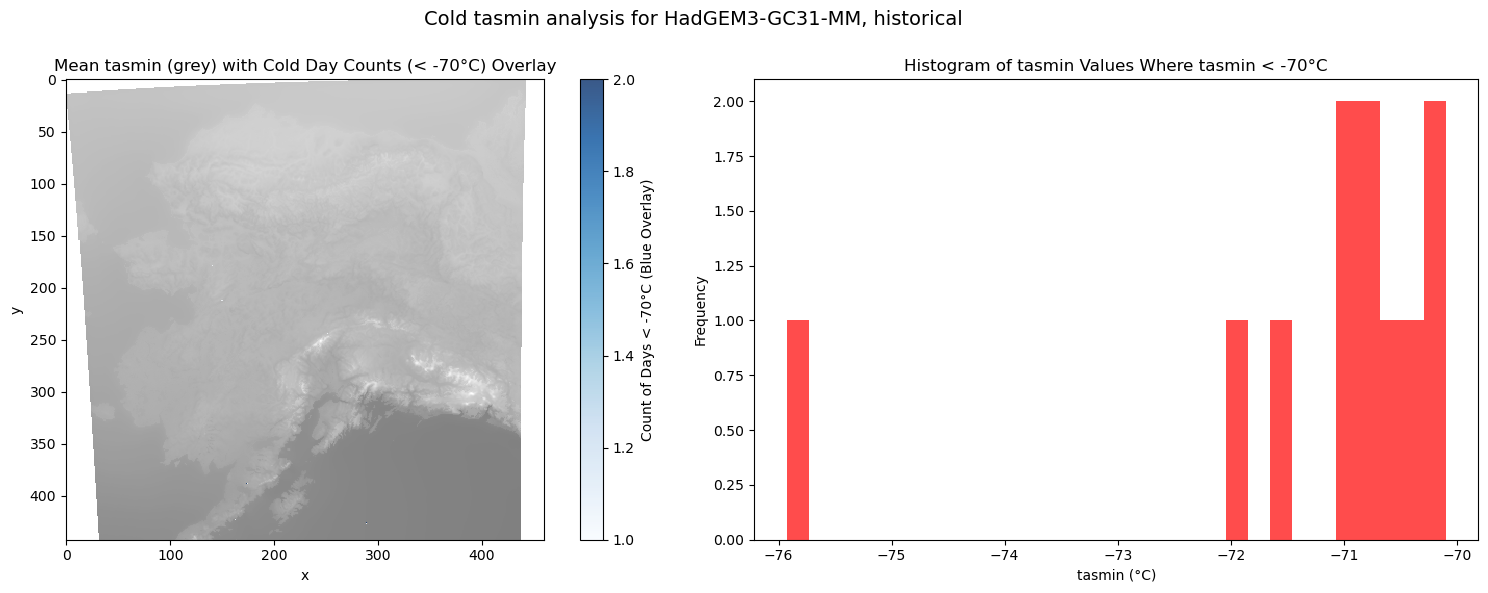

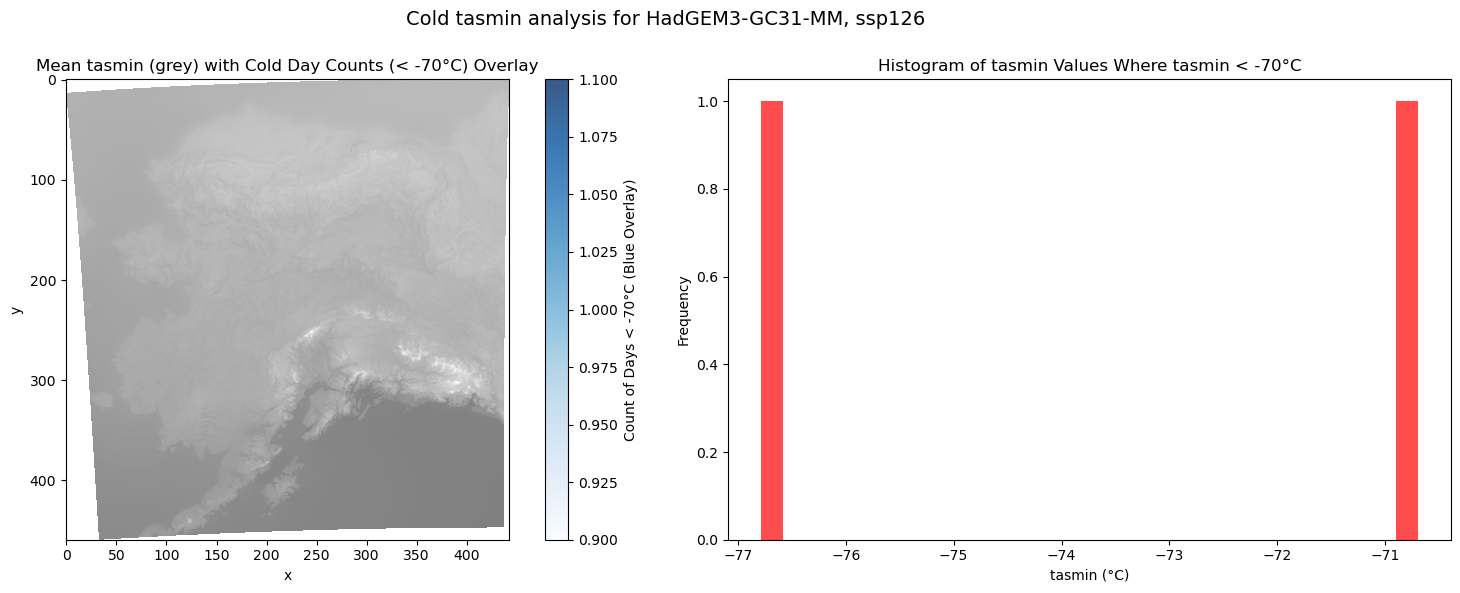

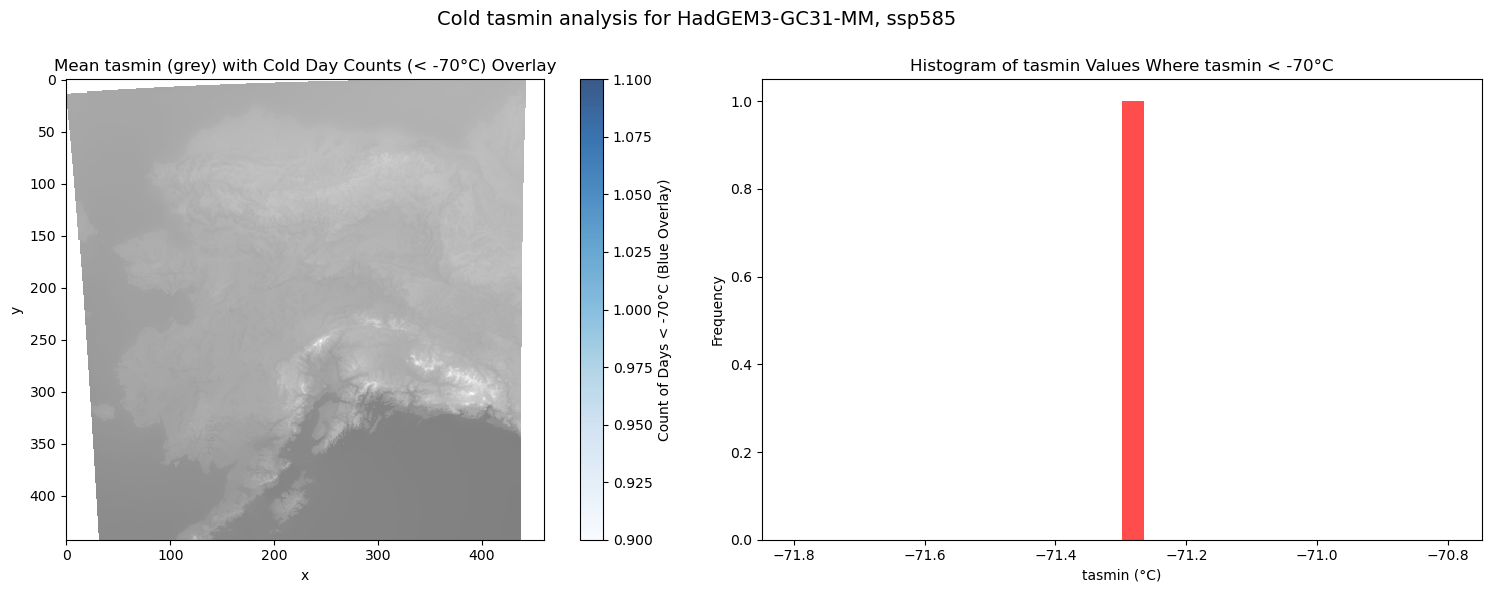

In [ ]:
model = "HadGEM3-GC31-MM"
for scenario in ["historical", "ssp126", "ssp585"]:
    plot_cold_tasmin(model, scenario)

### KACE-1-0-G

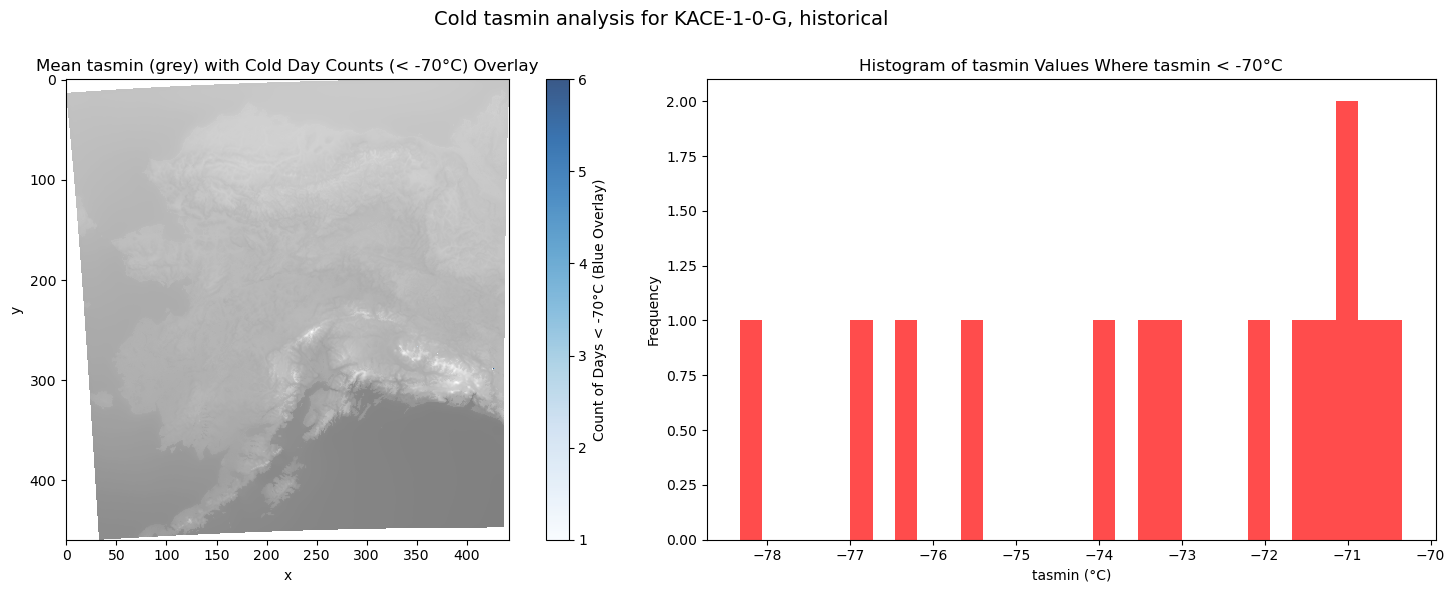

: 

In [ ]:
model = "KACE-1-0-G"
for scenario in ["historical"]:
    plot_cold_tasmin(model, scenario)

### MIROC6

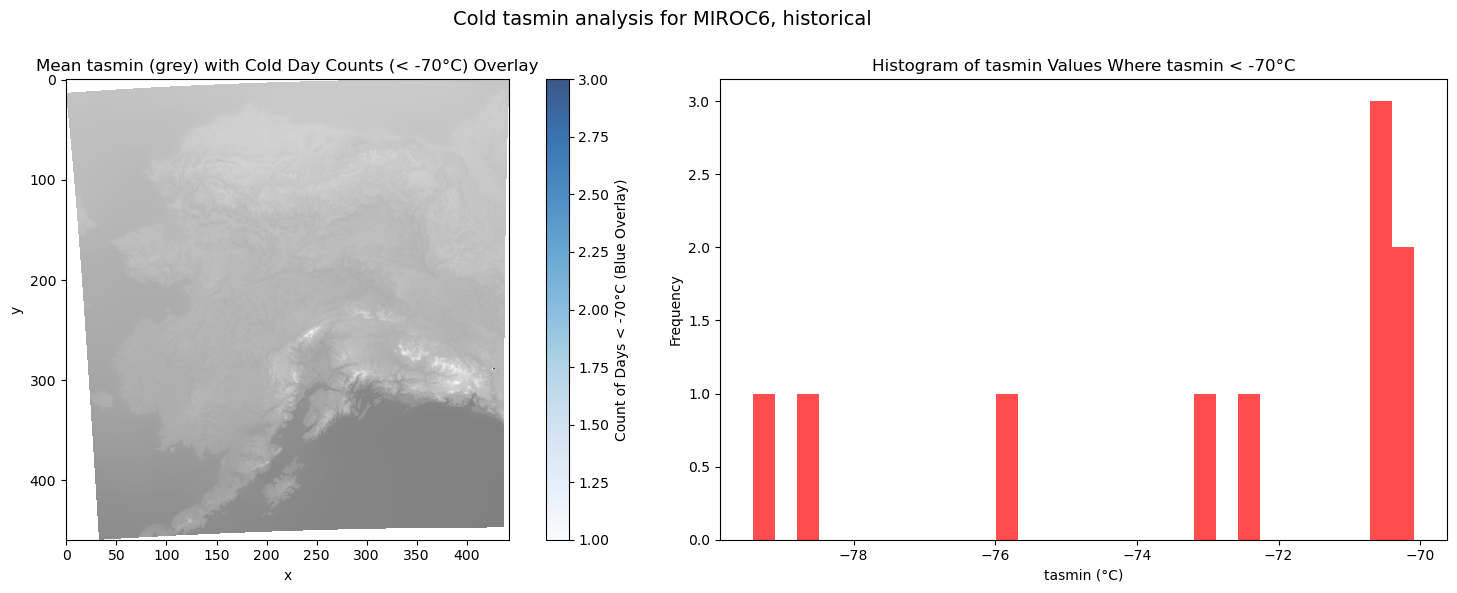

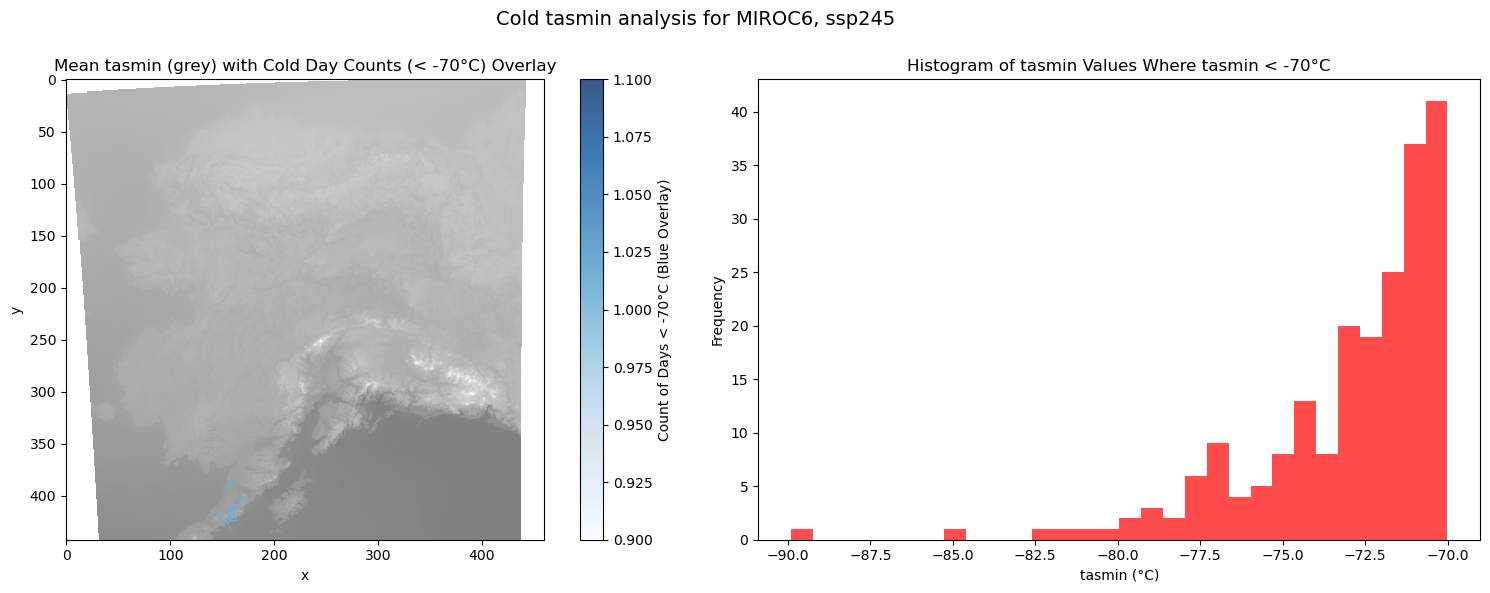

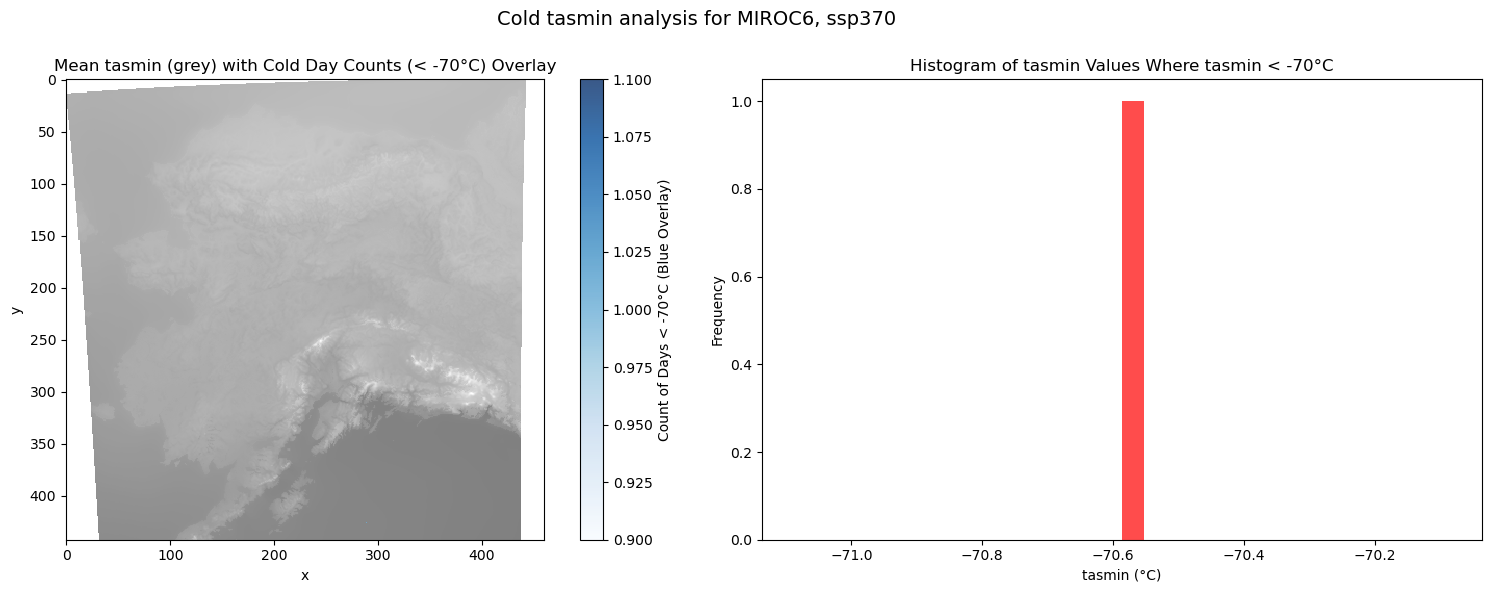

In [ ]:
model = "MIROC6"
for scenario in ["historical", "ssp245", "ssp370"]:
    plot_cold_tasmin(model, scenario)

### MPI-ESM1-2-HR

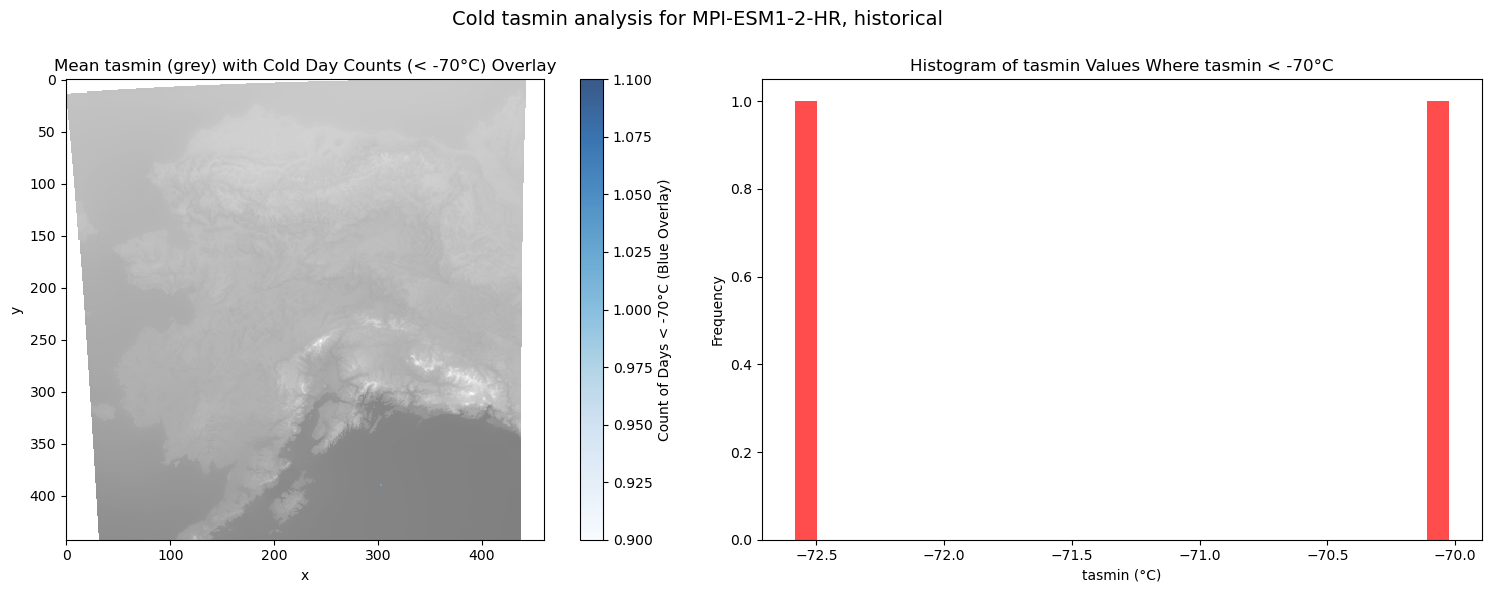

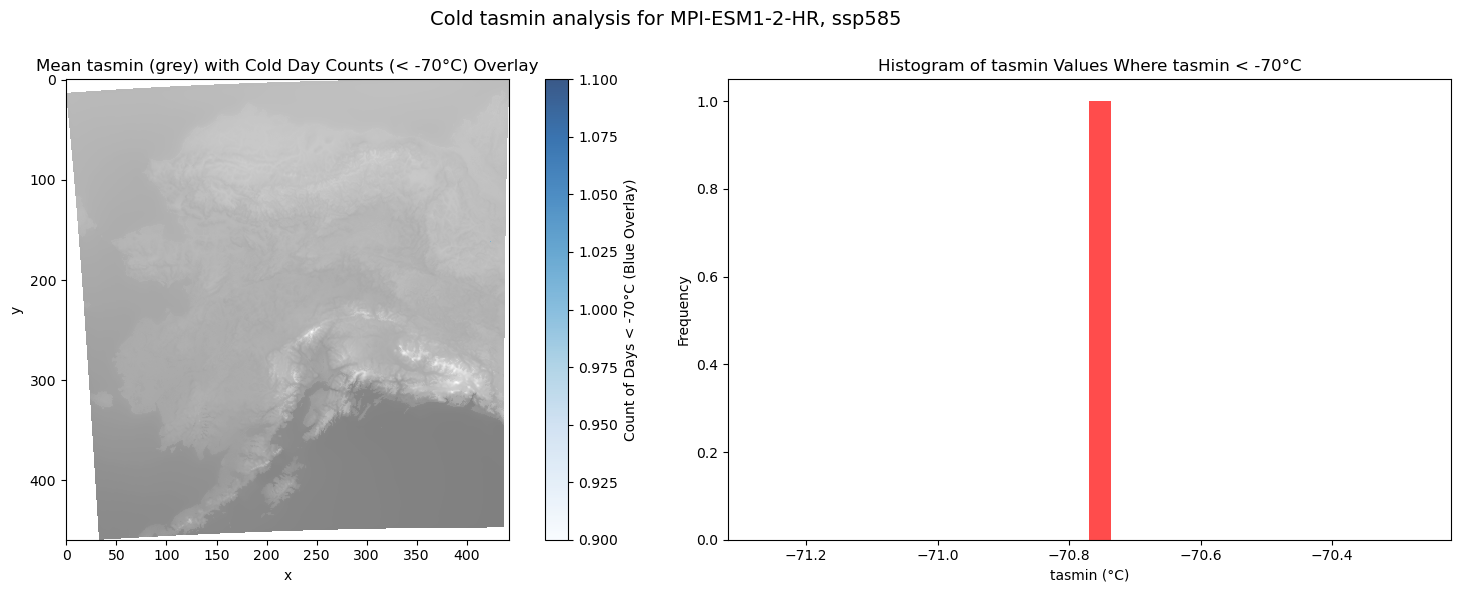

In [ ]:
model = "MPI-ESM1-2-HR"
for scenario in ["historical", "ssp585"]:
    plot_cold_tasmin(model, scenario)

### MRI-ESM2-0

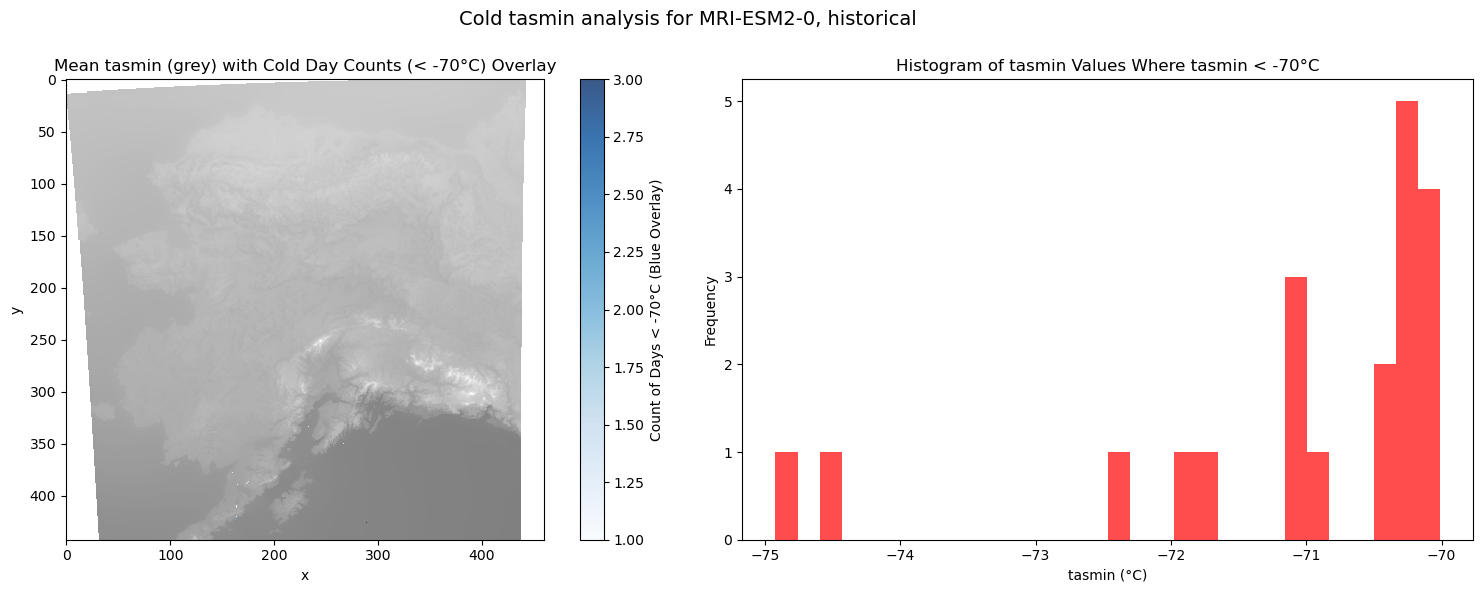

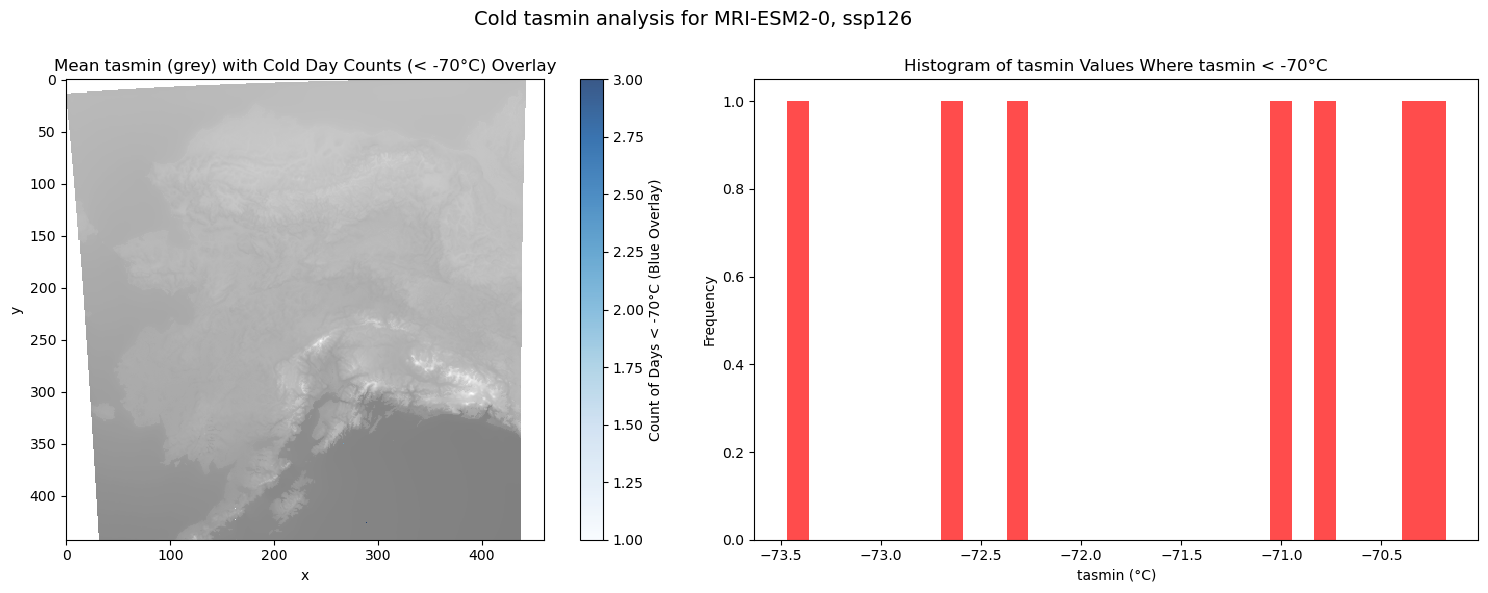

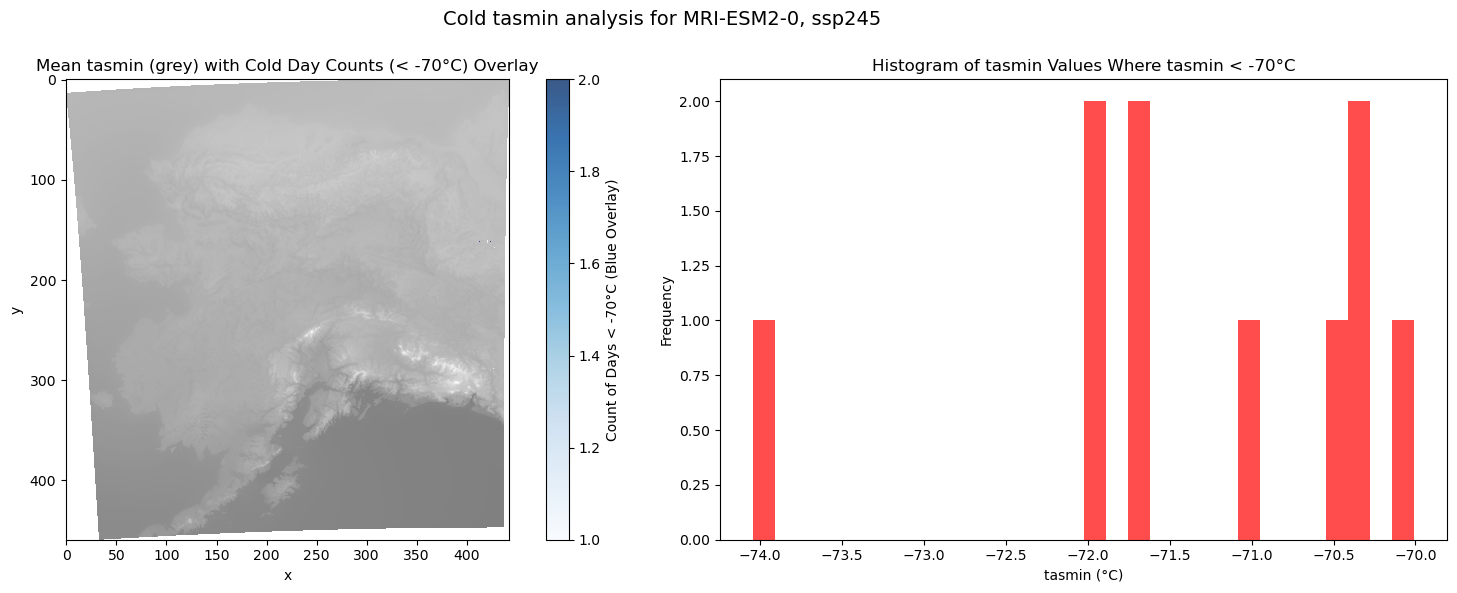

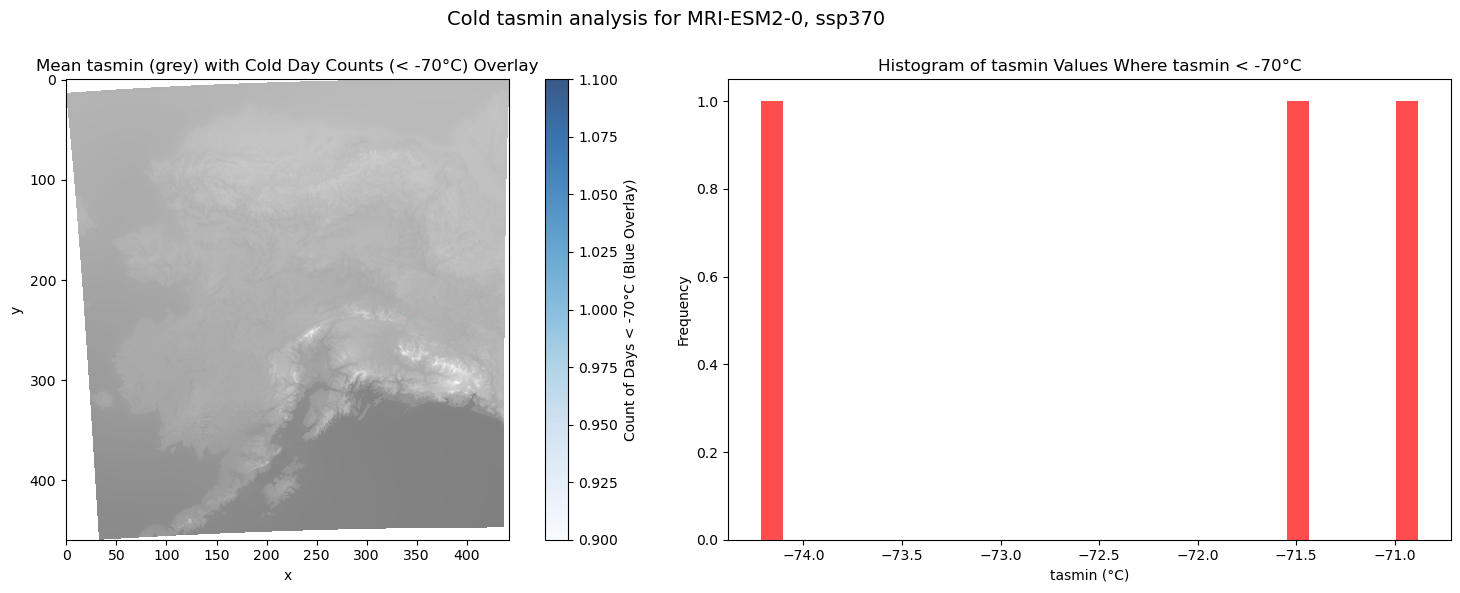

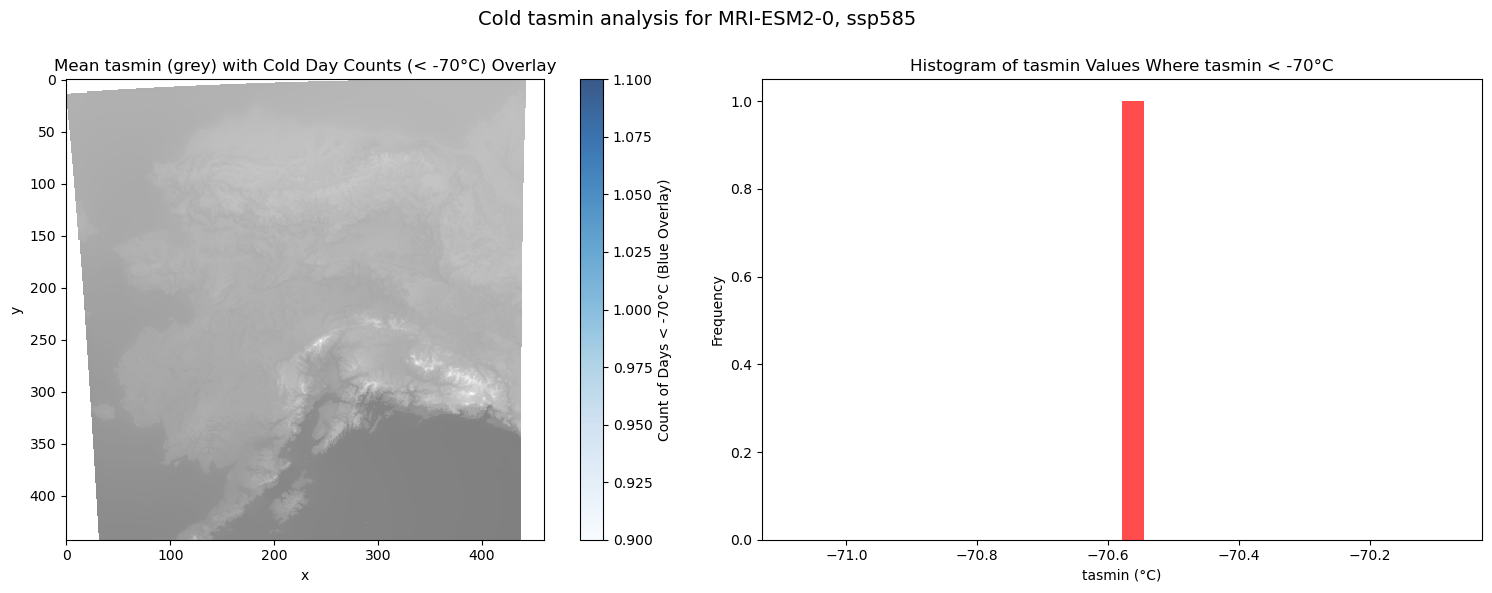

In [ ]:
model = "MRI-ESM2-0"
for scenario in ["historical", "ssp126", "ssp245", "ssp370", "ssp585"]:
    plot_cold_tasmin(model, scenario)

### NorESM2-MM

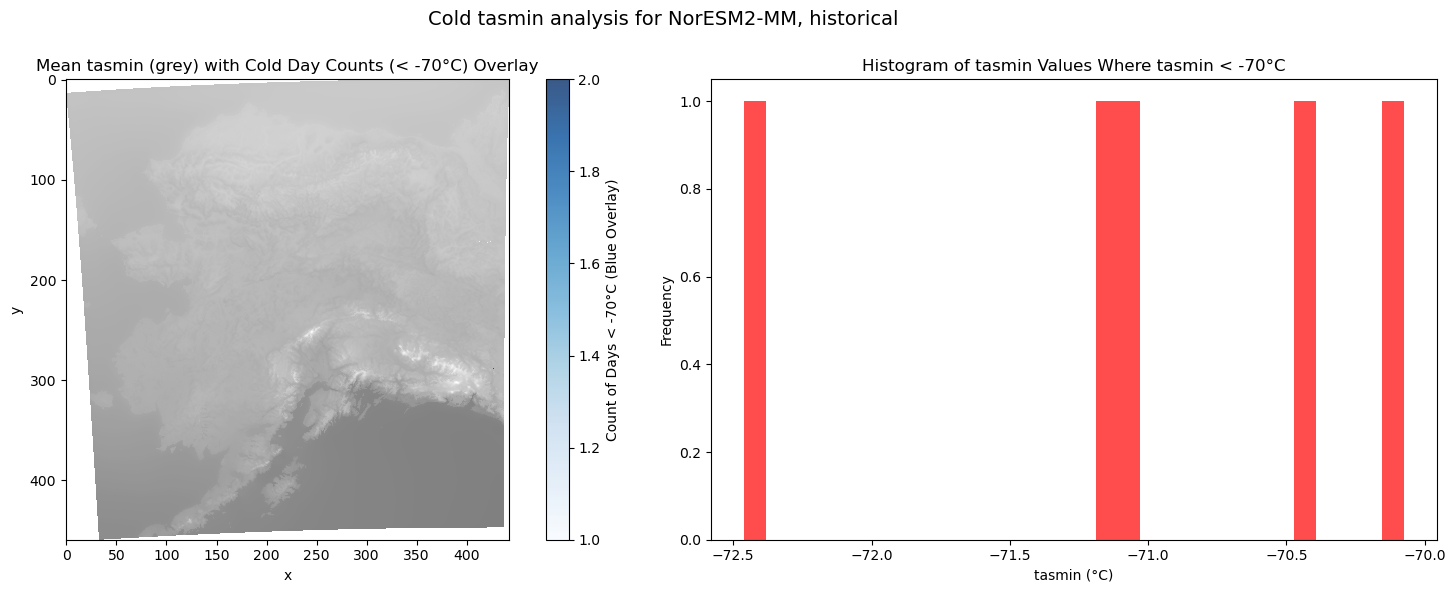

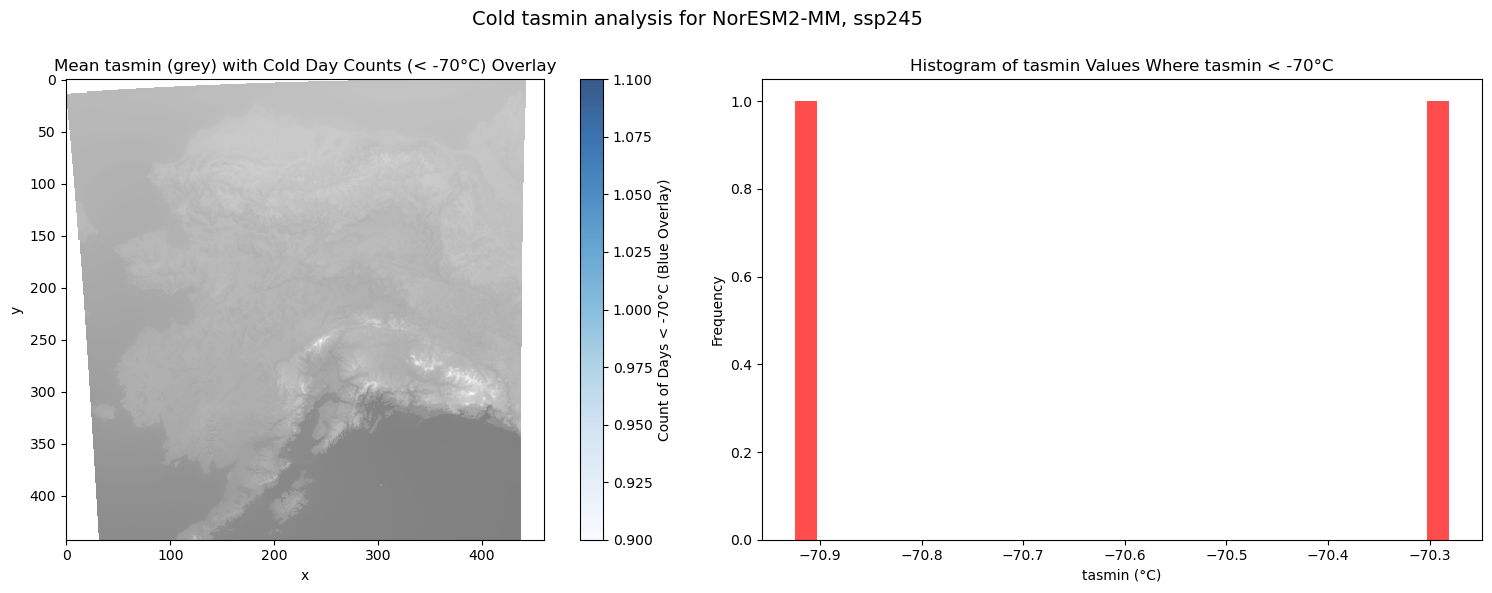

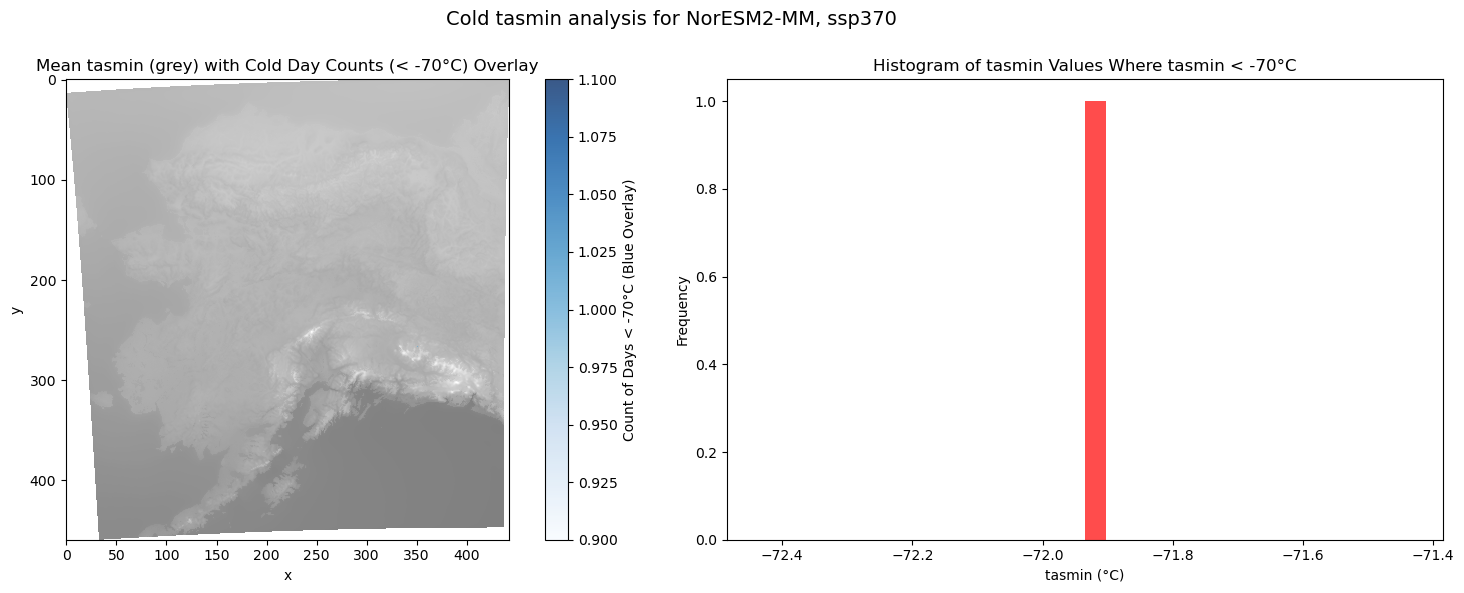

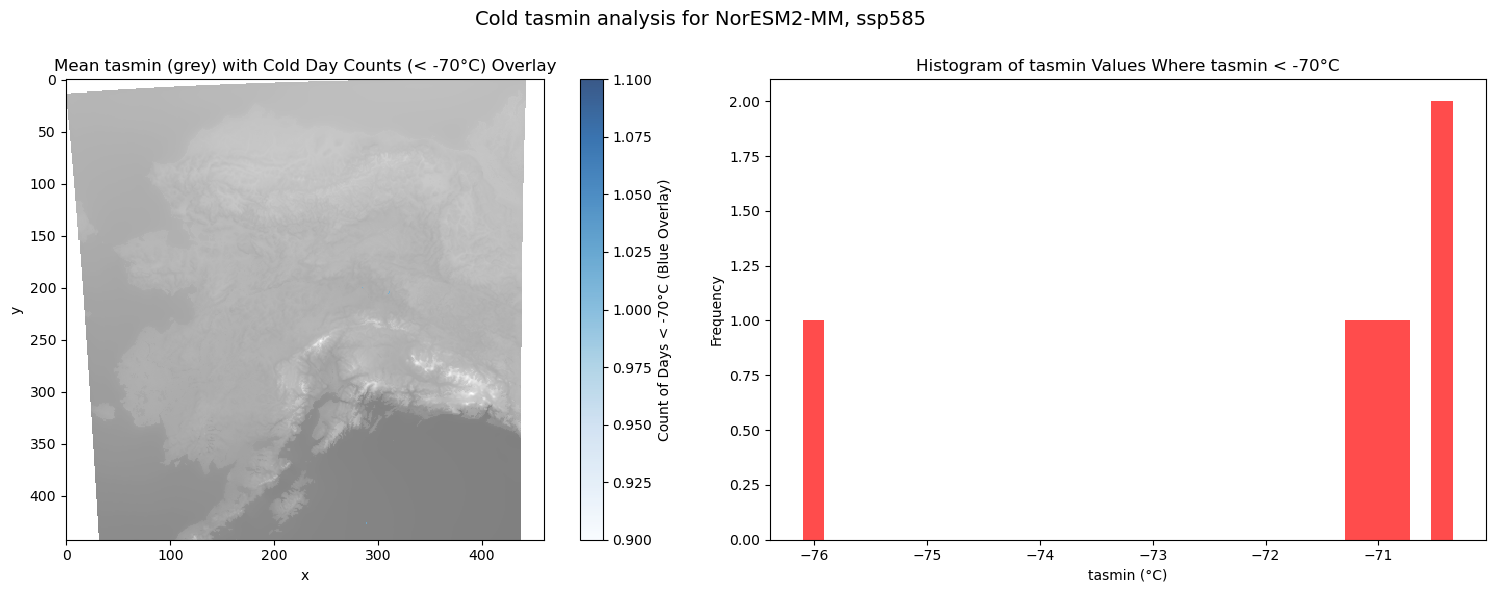

In [ ]:
model = "NorESM2-MM"
for scenario in ["historical", "ssp245", "ssp370", "ssp585"]:
    plot_cold_tasmin(model, scenario)

### TaiESM1

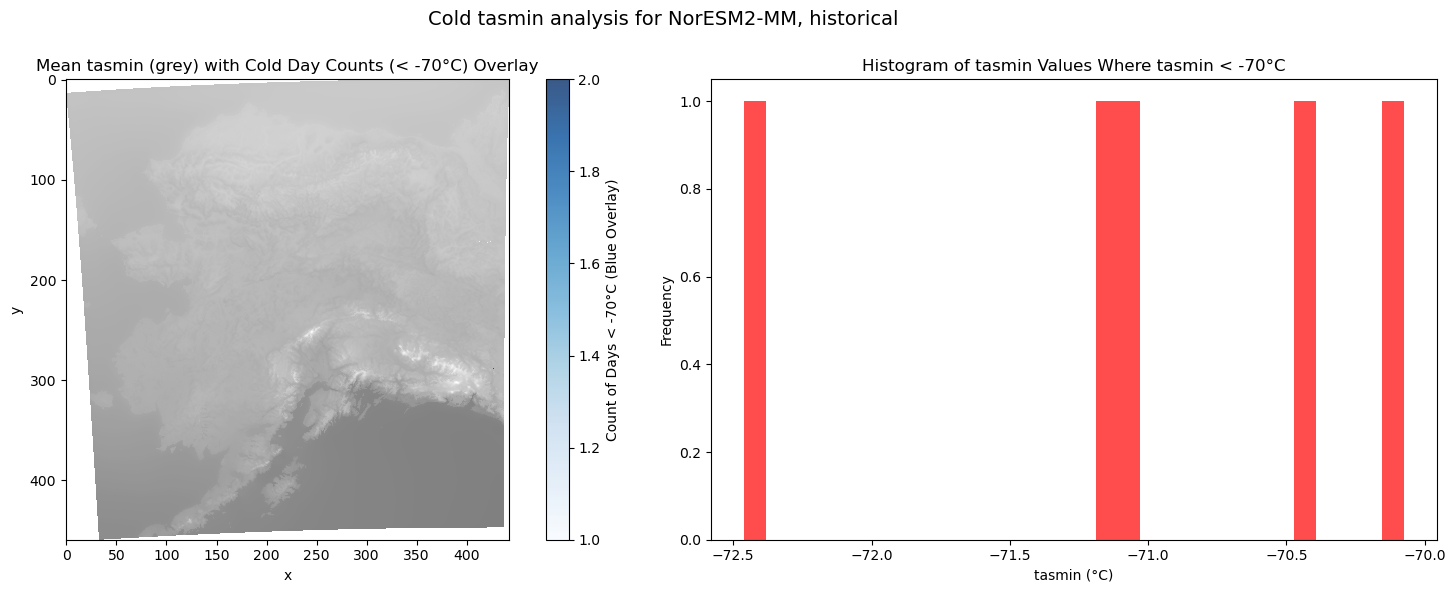

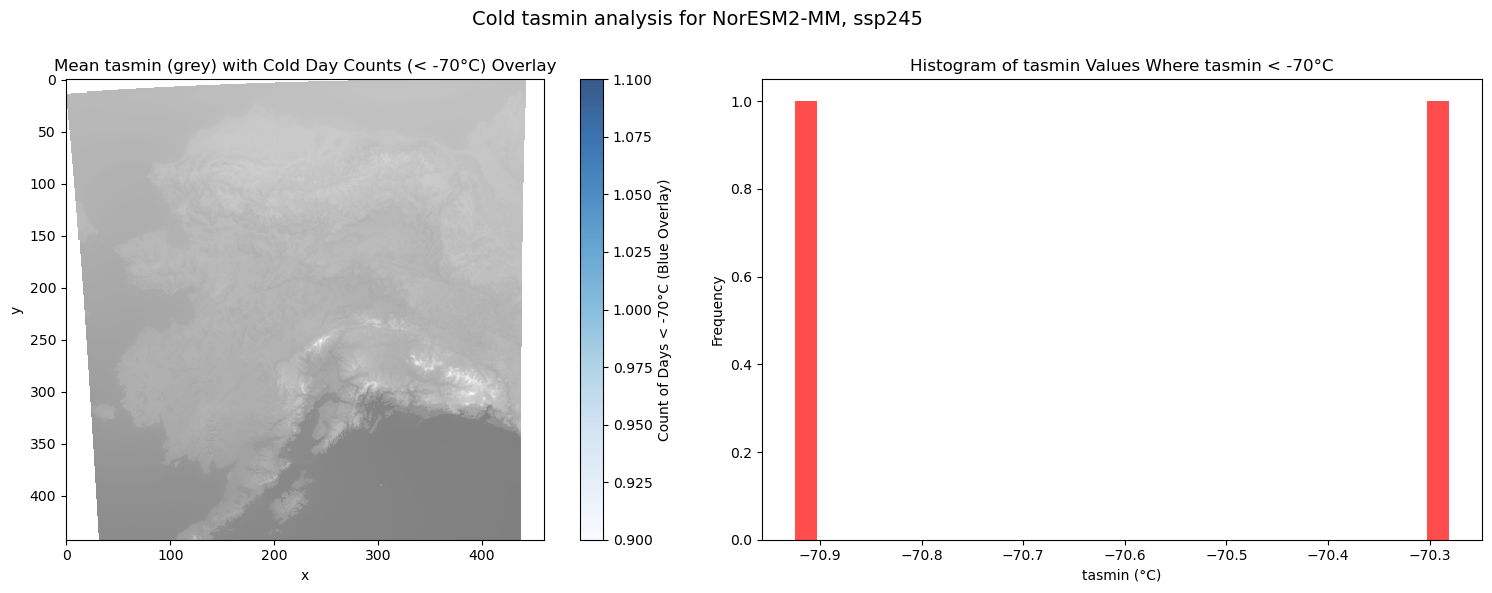

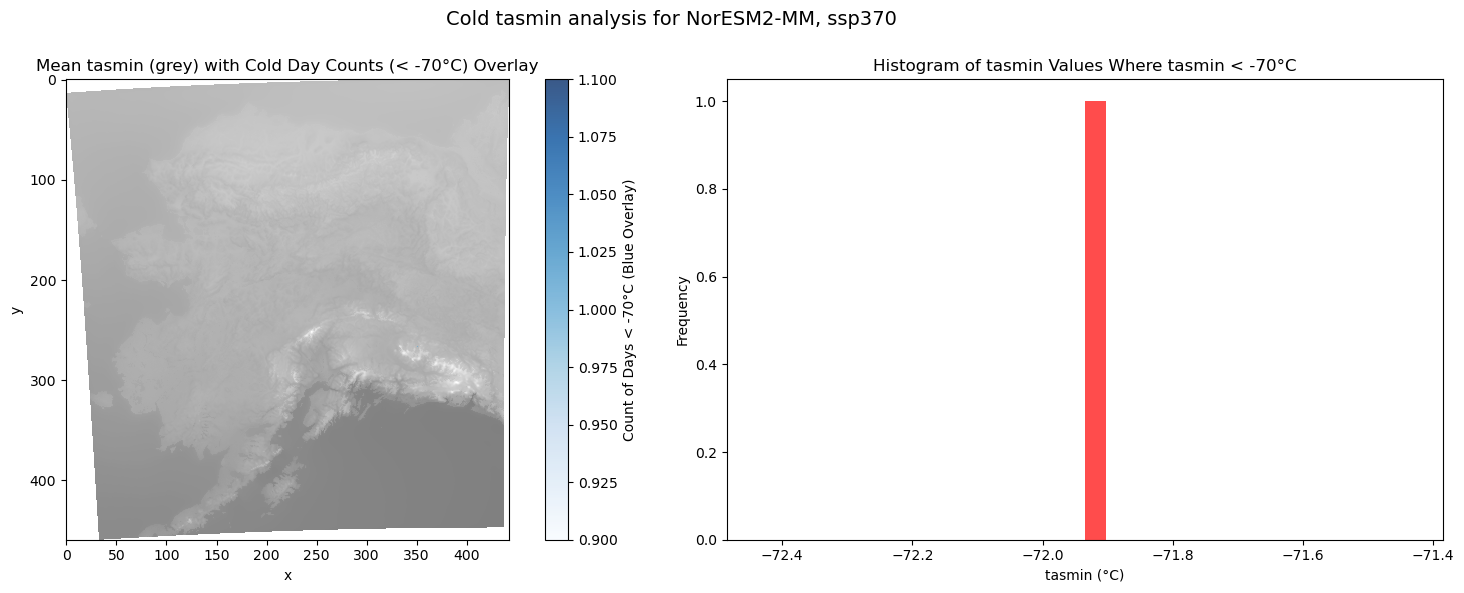

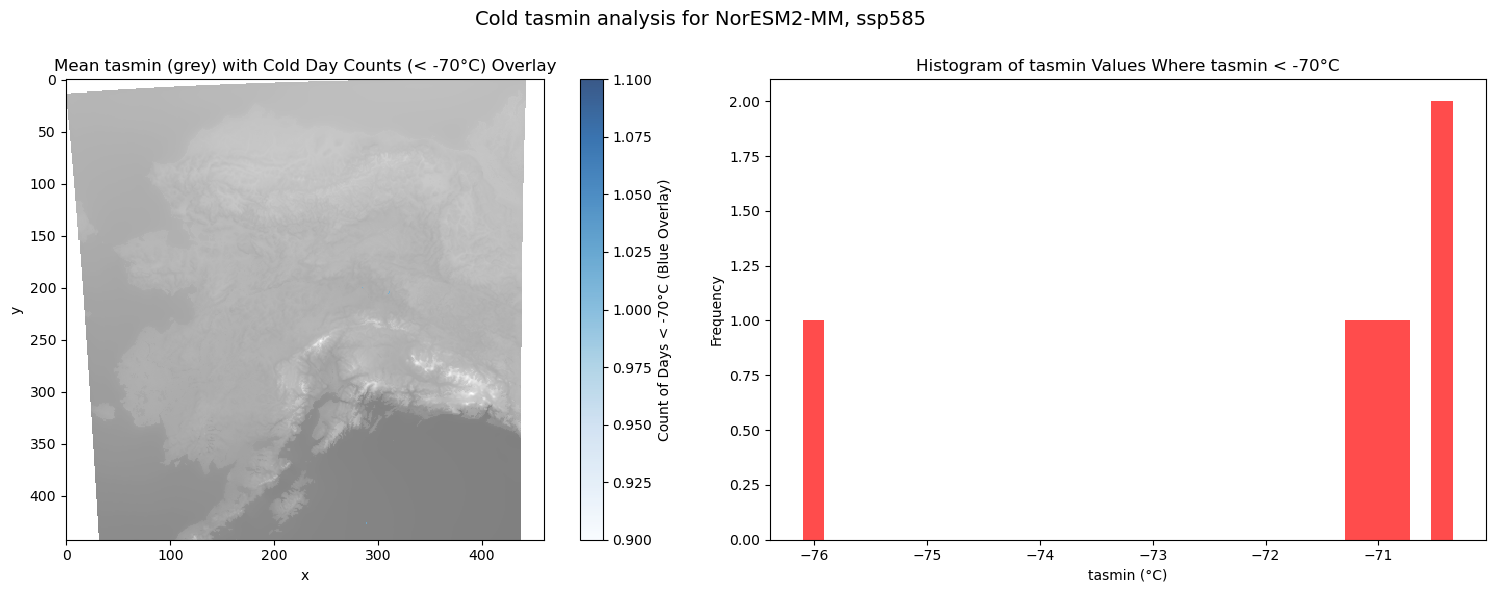

In [ ]:
model = "TaiESM1"
for scenario in ["historical", "ssp126", "ssp370", "ssp585"]:
    plot_cold_tasmin(model, scenario)

## Explore GFDL-ESM4

In [ ]:
def open_tasmin(model, scenario):
    zarr_store = zarr_dir.joinpath(f"tasmin_{model}_{scenario}_adjusted.zarr")
    ds = xr.open_zarr(zarr_store)
    tasmin = convert_units_to(ds.tasmin, "degC")
    return tasmin


def get_top6_cold_pixels(tasmin):
    # Count days below -70°C
    cold_days_count = (tasmin < -70).sum(dim="time").load()
    flat_cold = cold_days_count.values.flatten()

    top6_da = cold_days_count.where(
        cold_days_count >= np.sort(flat_cold)[-6], drop=True
    )
    top6_yx = np.argwhere(~np.isnan(top6_da.values))
    # limit to top 6
    top6_y = top6_da.y.values[top6_yx[:, 0]][:6]
    top6_x = top6_da.x.values[top6_yx[:, 1]][:6]

    return list(zip(top6_x, top6_y))


def plot_top6_cold_pixels(tasmin, top6_pixels):
    tasmin_mean = tasmin.mean("time")
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    tasmin_mean.transpose("y", "x").plot(ax=ax, cmap="Greys")
    top6_x, top6_y = zip(*top6_pixels)
    ax.scatter(top6_x, top6_y, color="blue", s=5, label="Top 6 Cold Pixels")
    plt.title("Mean tasmin with Top 6 Cold Pixels (<0°C) Highlighted")
    plt.legend()
    plt.show()


def plot_top6_cold_ecdfs(era5_ds, hist_ds, sim_ds, top6_pixels, thresh):
    n = len(top6_pixels)
    ncols = math.ceil(n / 2)
    nrows = 2

    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4), sharey=True)
    axs = axs.flatten()

    for i, (x, y) in enumerate(top6_pixels):
        era5_extr = era5_ds.dtr.sel(x=x, y=y)
        hist_extr = hist_ds.dtr.sel(x=x, y=y)
        sim_extr = sim_ds.dtr.sel(x=x, y=y)

        min_doy = hist_extr.where(
            hist_extr == hist_extr.min(), drop=True
        ).time.dt.dayofyear.item()
        doys = list(range(min_doy - 15, min_doy)) + list(range(min_doy, min_doy + 15))

        window_df = pd.concat(
            [
                hist_extr.sel(time=hist_extr.time.dt.dayofyear.isin(doys))
                .assign_coords(source=f"{model}_historical")
                .to_dataframe()
                .reset_index(),
                era5_extr.sel(time=era5_extr.time.dt.dayofyear.isin(doys))
                .assign_coords(source="ERA5")
                .to_dataframe()
                .reset_index(),
                sim_extr.sel(time=sim_extr.time.dt.dayofyear.isin(doys))
                .assign_coords(source=f"{model}_{scenario}")
                .to_dataframe()
                .reset_index(),
            ]
        )[["time", "source", "dtr"]]
        window_df["dtr"] = window_df["dtr"] - 273

        sns.ecdfplot(
            window_df.query(f"dtr > {thresh}"), x="dtr", hue="source", ax=axs[i]
        )
        axs[i].set_title(f"Pixel {i+1}\n(x={x:.0f}, y={y:.0f})")
        axs[i].set_xlabel("dtr (°C)")
        if i % ncols == 0:
            axs[i].set_ylabel("ECDF")
        else:
            axs[i].set_ylabel("")

    # Hide any unused subplots
    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axs[j])

    plt.suptitle(
        f"ECDF of DTR for Top 6 Cold Pixels (most occurrences of <0°C) for {model}",
        fontsize=16,
    )
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def plot_doy_means_tasmin(era5_ds, hist_ds, sim_ds, x, y):
    sim_doy_mean = convert_units_to(
        sim_ds["tasmin"].sel(x=x, y=y).groupby("time.dayofyear").mean(dim="time"),
        "degC",
    )
    hist_doy_mean = convert_units_to(
        hist_ds["tasmin"].sel(x=x, y=y).groupby("time.dayofyear").mean(dim="time"),
        "degC",
    )
    ref_doy_mean = convert_units_to(
        era5_ds["t2min"].sel(x=x, y=y).groupby("time.dayofyear").mean(dim="time"),
        "degC",
    )

    model = sim_ds.attrs.get("source_id")
    scenario = sim_ds.attrs.get("experiment_id")

    plt.figure(figsize=(10, 6))
    plt.plot(
        sim_doy_mean["dayofyear"],
        sim_doy_mean,
        label=f"{model} {scenario}",
        color="blue",
    )
    plt.plot(
        hist_doy_mean["dayofyear"],
        hist_doy_mean,
        label=f"{model} historical",
        color="orange",
    )
    plt.plot(ref_doy_mean["dayofyear"], ref_doy_mean, label="ERA5", color="green")
    plt.xlabel("Day of Year")
    plt.ylabel("tasmin (°C)")
    plt.title(f"Day-of-Year Mean tasmin: {model}, {scenario}, pixel: (x={x}, y={y})")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_cold_sim_tasmin(sim_ds):
    """plot cold tasmin pixels for unadjusted CMIP6 data"""
    tasmin = convert_units_to(sim_ds.tasmin, "degC")
    model = sim_ds.attrs.get("source_id")
    scenario = sim_ds.attrs.get("experiment_id")

    # Compute the mean tasmin over time
    tasmin_mean = tasmin.mean("time")

    tasmin_cold = tasmin < 0
    tasmin_cold_count = tasmin_cold.sum("time")

    # Prepare values for histogram
    tasmin_cold_values = tasmin.where(tasmin_cold).values.flatten()
    tasmin_cold_values = tasmin_cold_values[~np.isnan(tasmin_cold_values)]

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(
        f"Cold tasmin analysis for {model}, {scenario}, NOT bias-adjusted values",
        fontsize=14,
    )

    # Plot the mean tasmin as a muted background
    axs[0].imshow(
        tasmin_mean.transpose("y", "x").values,
        cmap="Greys",
        alpha=0.5,
        interpolation="none",
    )

    # Overlay the cold day counts using a blue color palette, masking zeros for clarity
    masked_cold = np.ma.masked_where(
        tasmin_cold_count.transpose("y", "x") == 0,
        tasmin_cold_count.transpose("y", "x"),
    )
    im = axs[0].imshow(masked_cold, cmap="Blues", alpha=0.8, interpolation="none")

    plt.colorbar(im, ax=axs[0], label="Count of Days < 0°C (Blue Overlay)")
    axs[0].set_title("Mean tasmin (grey) with Cold Day Counts (< 0°C) Overlay")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")

    # Histogram subplot
    if tasmin_cold_values.size > 0:
        axs[1].hist(tasmin_cold_values, bins=30, color="blue", alpha=0.7)
        axs[1].set_xlabel("tasmin (°C)")
        axs[1].set_ylabel("Frequency")
        axs[1].set_title("Histogram of tasmin Values Where tasmin < 0°C")
    else:
        axs[1].text(
            0.5,
            0.5,
            "No tasmin values below 0°C found.",
            ha="center",
            va="center",
            fontsize=12,
        )
        axs[1].set_axis_off()

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    del sim_ds
    del tasmin

    gc.collect()

In [4]:
ref_dir = Path("/center1/CMIP6/kmredilla/cmip6_4km_downscaling/era5_zarr")
era5_ds = xr.open_dataset(ref_dir.joinpath("tasmin_era5.zarr"))
era5_dtr_ds = xr.open_dataset(ref_dir.joinpath("dtr_era5.zarr"))

In [ ]:
model = "GFDL-ESM4"
scenario = "ssp585"

tasmin = open_tasmin(model, scenario)
top6_pixels = get_top6_cold_pixels(tasmin)

<Axes: ylabel='Density'>

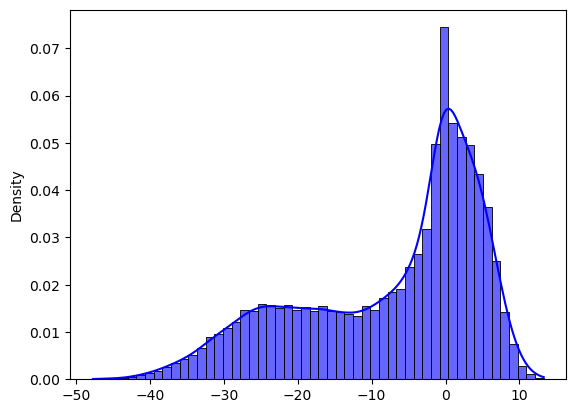

In [ ]:
model = "GFDL-ESM4"
scenario = "ssp585"
tasmax_ds = xr.open_dataset(sim_dir.joinpath(f"tasmax_{model}_{scenario}.zarr"))
dtr_ds = xr.open_dataset(sim_dir.joinpath(f"dtr_{model}_{scenario}.zarr"))
dtr_ds.dtr.attrs["units"] = "degC"

tasmax = convert_units_to(
    tasmax_ds.sel(x=top6_pixels[0][0], y=top6_pixels[0][1], method="nearest").tasmax,
    "degC",
)
dtr = convert_units_to(
    dtr_ds.sel(x=top6_pixels[0][0], y=top6_pixels[0][1], method="nearest").dtr, "degC"
)

sns.histplot((tasmax - dtr).values)

<Axes: ylabel='Count'>

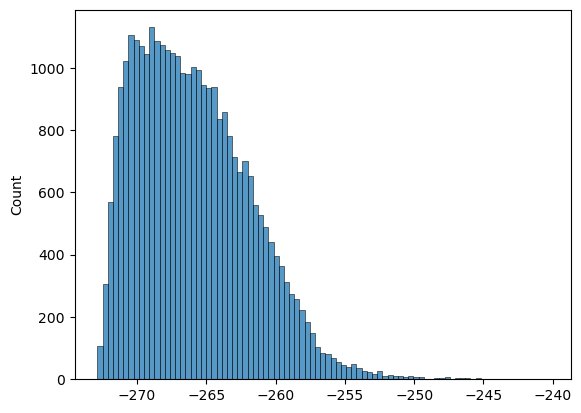

In [ ]:
model = "GFDL-ESM4"
scenario = "ssp585"
dtr_ds = xr.open_dataset(zarr_dir.joinpath(f"dtr_{model}_{scenario}_adjusted.zarr"))

dtr = convert_units_to(
    dtr_ds.sel(x=top6_pixels[0][0], y=top6_pixels[0][1], method="nearest").dtr, "degC"
)

sns.histplot(dtr)

Herein lies the problem with DTR for GFDL-ESM4. We may need to adjuste the preprocessing for this model.

In [ ]:
from xclim import sdba

era5_dtr_ds = xr.open_dataset(ref_dir.joinpath("dtr_era5.zarr"))
ref_dtr = (
    era5_dtr_ds["dtr"]
    .sel(
        x=top6_pixels[0][0],
        y=top6_pixels[0][1],
    )
    .convert_calendar("noleap")
)

model = "GFDL-ESM4"
hist_dtr_ds = xr.open_dataset(sim_dir.joinpath(f"dtr_{model}_historical.zarr"))
sim_dtr_ds = xr.open_dataset(sim_dir.joinpath(f"dtr_{model}_{scenario}.zarr"))

hist_dtr = (
    hist_dtr_ds["dtr"]
    .sel(x=top6_pixels[0][0], y=top6_pixels[0][1])
    .assign_coords(time=hist_ds.time.dt.floor("D"))
    .sel(time=slice("1965", "2014"))
)
sim_dtr = (
    sim_dtr_ds["dtr"]
    .sel(x=top6_pixels[0][0], y=top6_pixels[0][1])
    .assign_coords(time=sim_ds.time.dt.floor("D"))
    .sel(time=slice("2015", "2100"))
)

print("10 smallest DTR values for sim_dtr:", np.sort(sim_dtr.values)[:10])
print("10 smallest DTR values for hist_dtr:", np.sort(hist_dtr.values)[:10])

# apply jitter

jitter_under_thresh = "1e-4 K"
hist_dtr_jit = sdba.processing.jitter_under_thresh(hist_dtr, thresh=jitter_under_thresh)
sim_dtr = sdba.processing.jitter_under_thresh(sim_dtr, thresh=jitter_under_thresh)


print(
    "10 smallest DTR values for hist_dtr, after jitter:", np.sort(hist_dtr.values)[:10]
)

10 smallest DTR values for sim_dtr: [3.0517578e-05 9.9899997e-05 9.9899997e-05 9.9899997e-05 9.9899997e-05
 9.9899997e-05 9.9899997e-05 9.9899997e-05 9.9899997e-05 9.9899997e-05]
10 smallest DTR values for hist_dtr: [0.00e+00 9.99e-05 9.99e-05 9.99e-05 9.99e-05 9.99e-05 9.99e-05 9.99e-05
 9.99e-05 9.99e-05]
10 smallest DTR values for hist_dtr, after jitter: [0.00e+00 9.99e-05 9.99e-05 9.99e-05 9.99e-05 9.99e-05 9.99e-05 9.99e-05
 9.99e-05 9.99e-05]


In [ ]:
from xclim.sdba import QuantileDeltaMapping

thresh = "1e-4 K"
hist_dtr_jit = sdba.processing.jitter_under_thresh(hist_dtr, thresh=thresh)

train_kwargs = dict(
    ref=ref_dtr,
    hist=hist_dtr_jit,
    group="time.dayofyear",
    window=31,
    nquantiles=50,
    kind="*",
)

qdm = QuantileDeltaMapping.train(**train_kwargs)
scen = qdm.adjust(sim_dtr)

In [ ]:
# Maximum ERA5 value for this pixel
ref_dtr.max()

<xarray.DataArray 'dtr' ()> Size: 8B
array(23.87548828)
Coordinates:
    x        float64 8B -4.348e+05
    y        float64 8B 2.324e+06

In [67]:
np.sort(scen[(20 < scen) & (scen < 100)].values)

array([20.523829, 20.615187, 20.617294, 21.321203, 22.348526, 24.524164,
       24.535027, 47.22223 , 50.1184  , 72.19028 , 94.251656, 96.84099 ,
       98.127914], dtype=float32)

<Axes: >

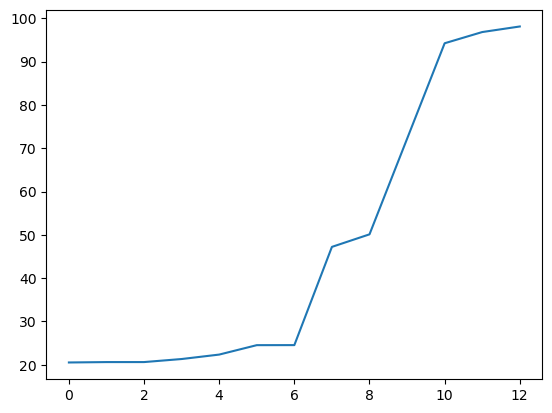

In [64]:
sns.lineplot(np.sort(scen[(20 < scen) & (scen < 100)]))

<Axes: ylabel='Count'>

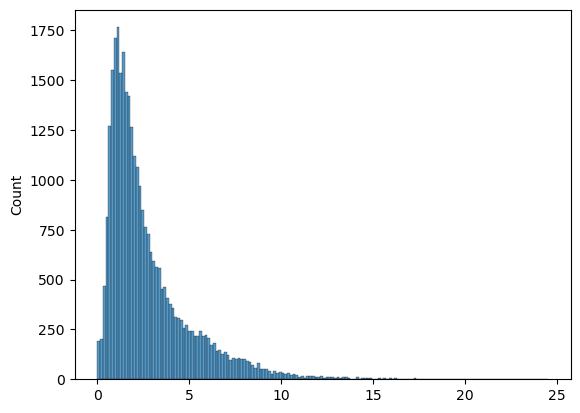

In [46]:
sns.histplot(scen[scen < 40])

In [ ]:
scen = qdm.adjust(sim_dtr)
sns.histplot(scen)

So we are seeing some huge DTR values. Why?

In [ ]:
af = qdm.ds.af
max_idx = np.unravel_index(np.nanargmax(af.values), af.shape)
max_dayofyear = af["dayofyear"].values[max_idx[0]]
max_quantile = af["quantiles"].values[max_idx[1]]
max_value = af.values[max_idx]

print(f"Largest af value: {max_value}")
print(f"dayofyear: {max_dayofyear}, quantile: {max_quantile}")

Largest af value: 28372.412109375
dayofyear: 178, quantile: 0.009999999776482582


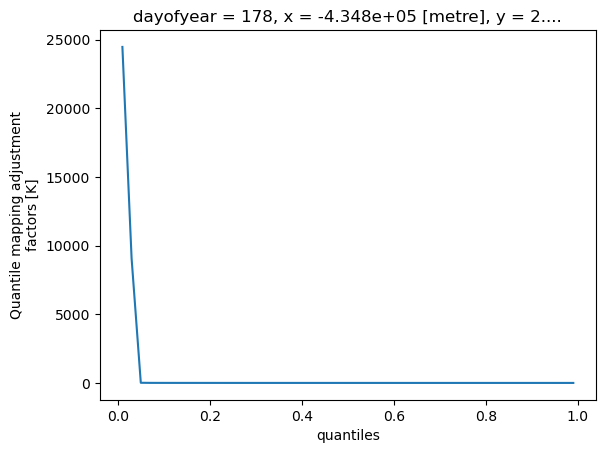

In [9]:
qdm.ds.af.sel(dayofyear=178).plot()

TypeError: 'NoneType' object is not iterable

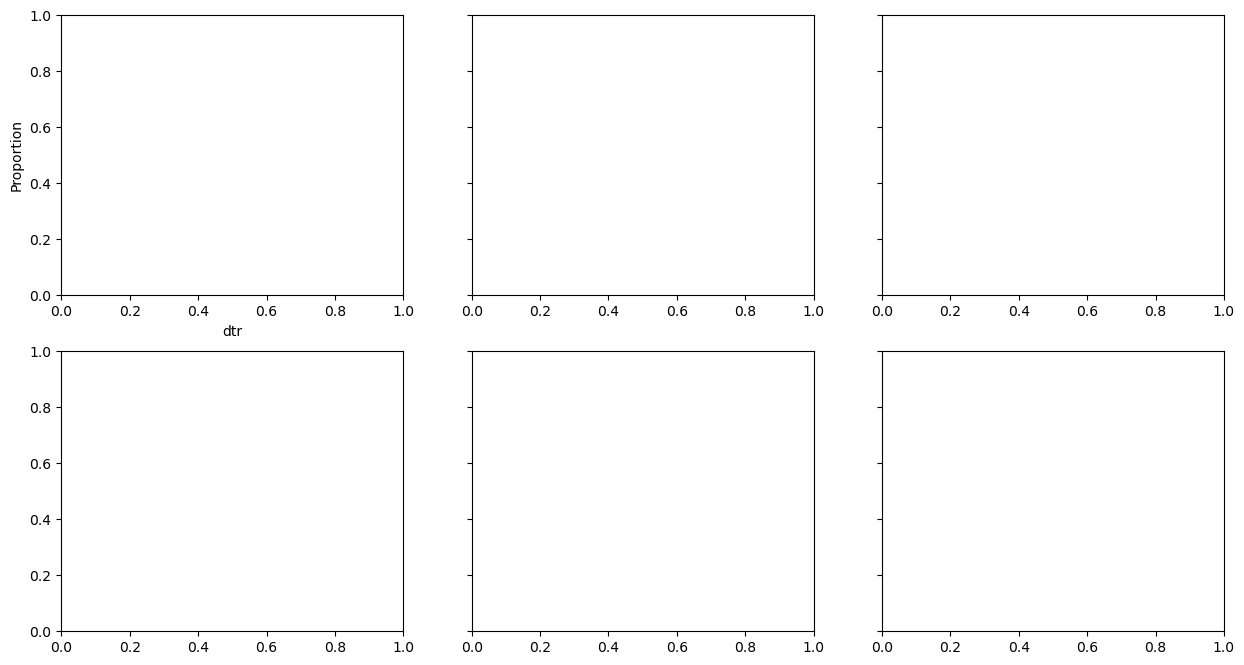

In [ ]:
plot_top6_cold_ecdfs(era5_dtr_ds, hist_ds, sim_ds, top6_pixels, thresh=0)

Top 6 (x, y) coordinates with highest counts of days < -70°C:
1. (x: -434840.36, y: 2323930.44), count below -70°C: 96
2. (x: -438849.18, y: 2319921.61), count below -70°C: 98
3. (x: -434840.36, y: 2319921.61), count below -70°C: 90
4. (x: -430831.53, y: 2319921.61), count below -70°C: 88
5. (x: -434840.36, y: 2315912.79), count below -70°C: 92
6. (x: -430831.53, y: 2315912.79), count below -70°C: 91


/home/kmredilla/miniconda3/envs/cmip6-utils/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


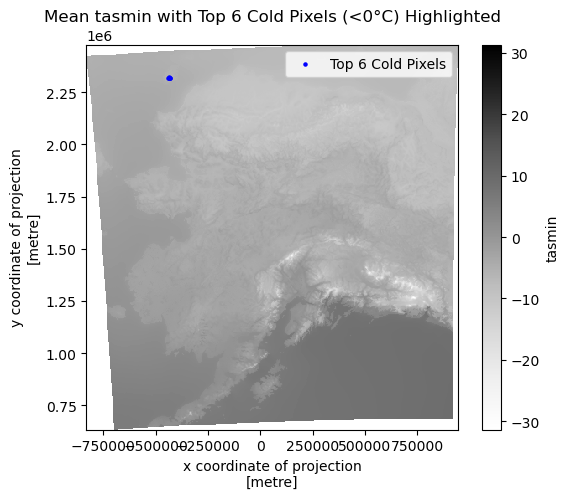

AttributeError: 'Dataset' object has no attribute 't2min'

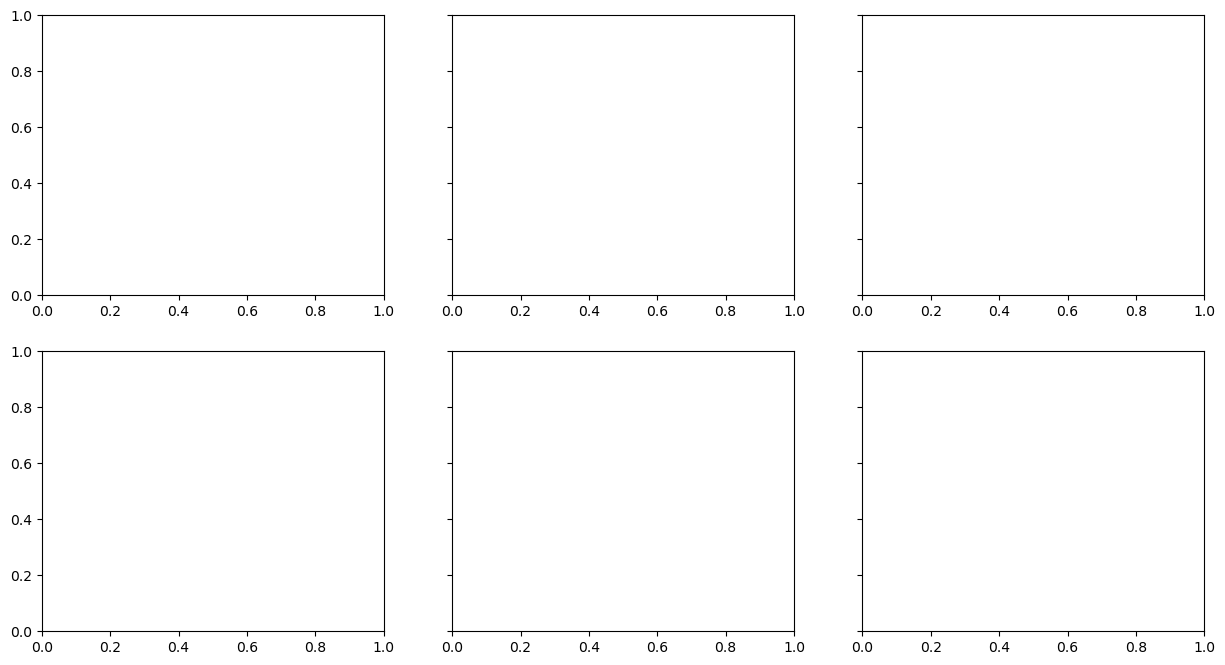

In [ ]:
# open the downscaled dataset
model = "GFDL-ESM4"
scenario = "ssp585"

tasmin = open_tasmin(model, scenario)
top6_pixels = get_top6_cold_pixels(tasmin)

print("Top 6 (x, y) coordinates with highest counts of days < -70°C:")
for idx, (x, y) in enumerate(top6_pixels, start=1):
    print(
        f"{idx}. (x: {x:.2f}, y: {y:.2f}), count below -70°C: {(tasmin.sel(x=x, y=y).values < -70).sum()}"
    )

plot_top6_cold_pixels(tasmin, top6_pixels)

# open unadjusted, regridded DTR data
hist_ds = xr.open_dataset(sim_dir.joinpath(f"dtr_{model}_historical.zarr"))
sim_ds = xr.open_dataset(sim_dir.joinpath(f"dtr_{model}_{scenario}.zarr"))

plot_top6_cold_ecdfs(era5_dtr_ds, hist_ds, sim_ds, top6_pixels, thresh=0)
# plot_doy_means_tasmin(era5_dtr_ds, hist_ds, sim_ds, x=top6_pixels[0][0], y=top6_pixels[0][1])
# plot_cold_sim_tasmin(sim_ds)